Hello, this is a Python Notebook that will explain the project I did for my Master's Thesis. The code has been updated in the last months.

In [54]:
import os
from datetime import datetime
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math
import emcee
import pandas as pd
import scipy.stats as stats
import getdist
from getdist import plots, MCSamples
from pathlib import Path
PROJECT_ROOT = Path.cwd()

In [55]:
# CONFIGURATION PARAMETERS
# Define configuration dictionary
config_dict = {
    'Parameter': [
        'N_CLUSTERS',
        'TEST',
        'DPI',
        'nwalkers',
        'niter',
        'nburnin',
        'w',
        'ANALYSIS',
        'NPARAMS'
    ],
    'Value': [
        75,      # Number of clusters
        0,       # Test mode (0=test, 1=production)
        None,    # Set below based on TEST
        None,    # Set below based on TEST
        None,    # Set below based on TEST
        None,    # Set below based on TEST
        1.0,     # Baryonic mass fraction
        1,       # Analysis type (0=initial, 1=complete)
        2        # Number of MCMC parameters
    ],
    'Description': [
        'Number of clusters: 99=all, 75=purged (lower temp uncertainty)',
        'Test mode: 0=test (fast), 1=production (high quality)',
        'Plot resolution in dots per inch',
        'Number of MCMC walkers',
        'Number of MCMC iterations per chain',
        'Number of discarded burn-in iterations',
        'Mass fraction: 1.0=hot gas only, 1.3=hot gas + galaxies',
        'Analysis type: 0=ε₀ & BTFR slope, 1=complete gravitational permittivity',
        'Num params: 1=slope only, 2=ε₀+α or ε₀+ρc, 3=ε₀+ρc+Q, 4=all params'
    ]
}

# Create DataFrame
config_df = pd.DataFrame(config_dict)

# Set values based on TEST mode
TEST = config_df[config_df['Parameter'] == 'TEST']['Value'].values[0]
N_CLUSTERS = config_df[config_df['Parameter'] == 'N_CLUSTERS']['Value'].values[0]
w = config_df[config_df['Parameter'] == 'w']['Value'].values[0]
ANALYSIS = config_df[config_df['Parameter'] == 'ANALYSIS']['Value'].values[0]
NPARAMS = config_df[config_df['Parameter'] == 'NPARAMS']['Value'].values[0]

if (TEST == 0):
    # Test mode - faster, but lower quality
    DPI = 100
    nwalkers = 100
    niter = 10000
    nburnin = 100
elif (TEST == 1):
    # Production mode - slower, but high quality
    DPI = 600
    nwalkers = 200
    niter = 80000
    nburnin = 6000

# Update DataFrame with computed values
config_df.loc[config_df['Parameter'] == 'DPI', 'Value'] = DPI
config_df.loc[config_df['Parameter'] == 'nwalkers', 'Value'] = nwalkers
config_df.loc[config_df['Parameter'] == 'niter', 'Value'] = niter
config_df.loc[config_df['Parameter'] == 'nburnin', 'Value'] = nburnin

# Display the dataframe
config_df

,Parameter,Value,Description
0,N_CLUSTERS,75.0,"Number of clusters: 99=all, 75=purged (lower t..."
1,TEST,0.0,"Test mode: 0=test (fast), 1=production (high q..."
2,DPI,100.0,Plot resolution in dots per inch
3,nwalkers,100.0,Number of MCMC walkers
4,niter,10000.0,Number of MCMC iterations per chain
5,nburnin,100.0,Number of discarded burn-in iterations
6,w,1.0,"Mass fraction: 1.0=hot gas only, 1.3=hot gas +..."
7,ANALYSIS,1.0,"Analysis type: 0=ε₀ & BTFR slope, 1=complete g..."
8,NPARAMS,2.0,"Num params: 1=slope only, 2=ε₀+α or ε₀+ρc, 3=ε..."


In [56]:
#Different colors for the chains and the cornerplot in different configurations
plt.rcParams['font.family'] = 'serif'

if (ANALYSIS == 0):
  if (NPARAMS == 2):
    color_chain = "royalblue"
    color_cornerplot = "navy"
  elif (NPARAMS == 1):
    color_chain = "royalblue"
    color_cornerplot = "navy"
elif (ANALYSIS == 1):
  if (NPARAMS == 2):
    color_chain = "slategrey"
    color_cornerplot = "darkred"
  elif (NPARAMS == 3):
    color_chain = "slategrey"
    color_cornerplot = "darkred"
  elif (NPARAMS == 4):
    color_chain = "slategrey"
    color_cornerplot = "darkred"

In [57]:
# Create the DataFrame from physical constants
constants_dict = {
  'Constant': [
    'PI', 'B_MOND', 'G_PC_SM_KM_S', 'G_SI',
    'M_S', 'PC', 'm_p', 'm_p_kg', 'c_speed',
    'mu', 'OMEGA_M', 'OMEGA_L', 'h_0', 'lambda_cooling'
  ],
  'Value': [
    math.pi, 1.2e-10, 0.004300917, 6.67430e-11,
    1.98840987e30 , 3.08567758e16, 938.27208816, 1.67262192e-27, 299792.458,
    0.58, 0.3, 0.7, 0.7, 0.843e-23
  ],
  'Units': [
    'dimensionless', 'm/s²', 'pc/(M☉·(km/s)²)', 'Nm²/kg² = m³/(kg·s²)',
    'kg', 'm', 'MeV/c²', 'kg', 'km/s', 
    'dimensionless', 'dimensionless', 'dimensionless', 'dimensionless', 'erg/s·cm³'
  ],
  'Description': [
    'Pi constant', 'Acceleration scale for MOND', 'Gravitational constant (parsec units)', 'Gravitational constant (SI units)',
    'Solar mass', 'Parsec', 'Proton mass', 'Proton mass', 'Speed of light',
    'Mean molecular weight', 'Mass density parameter', 'Dark energy density parameter', 'Hubble parameter', 'Cooling function'
  ]
}

constants_df = pd.DataFrame(constants_dict)
constants_df

,Constant,Value,Units,Description
0,PI,3.141593e+00,dimensionless,Pi constant
1,B_MOND,1.200000e-10,m/s²,Acceleration scale for MOND
2,G_PC_SM_KM_S,4.300917e-03,pc/(M☉·(km/s)²),Gravitational constant (parsec units)
3,G_SI,6.674300e-11,Nm²/kg² = m³/(kg·s²),Gravitational constant (SI units)
4,M_S,1.988410e+30,kg,Solar mass
5,PC,3.085678e+16,m,Parsec
6,m_p,9.382721e+02,MeV/c²,Proton mass
7,m_p_kg,1.672622e-27,kg,Proton mass
8,c_speed,2.997925e+05,km/s,Speed of light
9,mu,5.800000e-01,dimensionless,Mean molecular weight


In [58]:
# Create DataFrame from physical constants parameters
parameters_dict = {
  'Constant': [
    'Ell_eps0', 'unc_Ell_eps0_p', 'unc_Ell_eps0_m',
    'Ell_rhoc', 'unc_Ell_rhoc_p', 'unc_Ell_rhoc_m',
    'Ell_Q',    'unc_Ell_Q_p',    'unc_Ell_Q_m',
    'Disk_eps0','unc_Disk_eps0',
    'Disk_rhoc', 'unc_Disk_rhoc',
    'Disk_Q', 'unc_Disk_Q',
    'slope_BTFR', 'unc_slope_BTFR_p', 'unc_slope_BTFR_m'
  ],
  'Value': [
    0.089, 0.038, 0.035,
    -24.25, 0.28, 0.20,
    0.47, 0.29, 0.21,
    0.56, 0.16,
    -25.30, 1.22, 
    0.92, 0.71,
    3.98, 0.12, 0.12
  ],
  'Description': [
    'ε₀ elliptical', 'upper uncertainty ε₀ elliptical', 'lower uncertainty ε₀ elliptical',
    'ρ_c elliptical', 'upper uncertainty ρ_c elliptical', 'lower uncertainty ρ_c elliptical',
    'Q elliptical', 'upper uncertainty Q elliptical', 'lower uncertainty Q elliptical',
    'ε₀ disk', 'uncertainty ε₀ disk',
    'ρ_c disk', 'uncertainty ρ_c disk',
    'Q disk', 'uncertainty Q disk',
    'BTFR slope', 'upper uncertainty BTFR slope', 'lower uncertainty BTFR slope'
  ]
}

params_df = pd.DataFrame(parameters_dict)
params_df

Ell_Q = parameters_dict['Value'][6] 
unc_Ell_Q_p = parameters_dict['Value'][7]
unc_Ell_Q_m = parameters_dict['Value'][8]
Disk_Q = parameters_dict['Value'][13]
unc_Disk_Q = parameters_dict['Value'][14]
Ell_eps0 = parameters_dict['Value'][0]
unc_Ell_eps0_p = parameters_dict['Value'][1]
unc_Ell_eps0_m = parameters_dict['Value'][2]
Disk_eps0 = parameters_dict['Value'][9]
unc_Disk_eps0 = parameters_dict['Value'][10]
slope_BTFR = parameters_dict['Value'][15]
unc_slope_BTFR_p = parameters_dict['Value'][16]
unc_slope_BTFR_m = parameters_dict['Value'][17]
Disk_rhoc = parameters_dict['Value'][11]
unc_Disk_rhoc = parameters_dict['Value'][12]
Ell_rhoc = parameters_dict['Value'][3]
unc_Ell_rhoc_p = parameters_dict['Value'][4]
unc_Ell_rhoc_m = parameters_dict['Value'][5]

In [59]:
## DATA ##
path_in = str(PROJECT_ROOT / "in" / "data_clusters_general")
if (N_CLUSTERS == 99):
  names = loadtxt(path_in+'/data_99/lists_clusters_99.txt', dtype=str)
  # X-ray LUMINOSITY
  L = loadtxt(path_in+'/data_99/luminosity_99.txt') # in units of 10^44 erg/s
  sigma_L = loadtxt(path_in+'/data_99/uncertainty_L_99.txt') # in units of 10^44 erg/s
  #RADIUS ------> obtained from Sohn et al. 2020
  R = loadtxt(path_in+'/data_99/radius_99.txt') # radius R_500 in units of Mpc
  sigma_R = R * 0.50 # in units of [Mpc]
  #TEMPERATURE of X-RAY GAS ----> obtained from Sohn et al. 2020
  T = loadtxt(path_in+'/data_99/temperature_99.txt') #in units of [keV]
  sigma_T = loadtxt(path_in+'/data_99/uncertainty_Temperature_99.txt') #in units of [keV]
  #VELOCITY DISPERSIONS ---> obtained from Sohn et al. 2020
  v_disp = loadtxt(path_in+'/data_99/velocity_dispersion_99.txt') #in units of [km/s]
  sigma_v_disp = loadtxt(path_in+'/data_99/uncertainty_v_dispersion_99.txt')
  #redshift
  z = loadtxt(path_in+'/data_99/redshift_99.txt')
elif (N_CLUSTERS == 75):
  names = loadtxt(path_in+'/data_75/list_clusters_75.txt', dtype=str)
  # X-ray LUMINOSITY
  L = loadtxt(path_in+'/data_75/luminosity_75.txt') # in units of 10^44 erg/s
  sigma_L = loadtxt(path_in+'/data_75/uncertainty_L_75.txt') # in units of 10^44 erg/s
  #RADIUS ------> obtained from Sohn et al. 2020
  R = loadtxt(path_in+'/data_75/radius_75.txt') # radius R_500 in units of Mpc
  sigma_R = R * 0.50 # in units of [Mpc]
  #TEMPERATURE of X-RAY GAS ----> obtained from Sohn et al. 2020
  T = loadtxt(path_in+'/data_75/temperature_75.txt') #in units of [keV]
  sigma_T = loadtxt(path_in+'/data_75/uncertainty_Temperature_75.txt') #in units of [keV]
  #VELOCITY DISPERSIONS ---> obtained from Sohn et al. 2020
  v_disp = loadtxt(path_in+'/data_75/velocity_dispersion_75.txt') #in units of [km/s]
  sigma_v_disp = loadtxt(path_in+'/data_75/uncertainty_vel_dispersion_75.txt')
  #redshift
  z = loadtxt(path_in+'/data_75/redshift_75.txt')

/var/folders/j4/6b1360d55ljdykkmtn15fj800000gn/T/ipykernel_30150/91734030.py:20: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  names = loadtxt(path_in+'/data_75/list_clusters_75.txt', dtype=str)


In [60]:
# CREATE RUN-SPECIFIC OUTPUT FOLDER STRUCTURE
# Create timestamped folder for this run
run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_folder = f'/Users/anvi/Desktop/0/out/run_{run_timestamp}/'

# Create subdirectories for different types of outputs
os.makedirs(run_folder, exist_ok=True)
os.makedirs(run_folder + 'plots/profiles/', exist_ok=True)
os.makedirs(run_folder + 'plots/mcmc/', exist_ok=True)
os.makedirs(run_folder + 'plots/histograms/', exist_ok=True)
os.makedirs(run_folder + 'plots/mass_velocity/', exist_ok=True)

# Update path variables to use the new run folder
tables = run_folder + 'tables/'
cornerplots_100 = run_folder + 'plots/mcmc/'
cornerplots_130 = run_folder + 'plots/mcmc/'
histograms = run_folder + 'plots/distributions/'
cornerplots = run_folder + 'plots/histograms/'
profiles = run_folder + 'plots/profiles/'
mass_vs_velocity = run_folder + 'plots/mass_velocity/'

print(f"Output folder created: {run_folder}")
print("All plots and results will be saved to this folder.")

Output folder created: /Users/anvi/Desktop/0/out/run_20260220_205527/
All plots and results will be saved to this folder.


In [61]:
# INITIALIZE RESULTS RECAP FILE
results_file = run_folder + 'results_recap.txt'
config_file = run_folder + 'config.txt'

# Save run configuration
with open(config_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("GALAXY CLUSTER ANALYSIS - RUN CONFIGURATION\n")
    f.write("="*70 + "\n")
    f.write(f"Run Timestamp: {run_timestamp}\n")
    f.write(f"Run Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write("CONFIGURATION PARAMETERS:\n")
    f.write("-"*70 + "\n")
    f.write(f"Number of clusters: {N_CLUSTERS}\n")
    f.write(f"Test mode: {TEST} ({'Test' if TEST == 0 else 'Production'})\n")
    f.write(f"DPI: {DPI}\n")
    f.write(f"Number of walkers: {nwalkers}\n")
    f.write(f"Number of iterations: {niter}\n")
    f.write(f"Number of burn-in steps: {nburnin}\n")
    f.write(f"Baryonic mass fraction (w): {w}\n")
    f.write(f"Analysis type: {ANALYSIS} ")
    if ANALYSIS == 0:
        f.write("(Initial study: ε₀ and BTFR slope)\n")
    else:
        f.write("(Complete gravitational permittivity)\n")
    f.write(f"Number of parameters: {NPARAMS}\n")
    f.write("="*70 + "\n")

# Initialize results recap file
with open(results_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("GALAXY CLUSTER ANALYSIS - RESULTS RECAP\n")
    f.write("="*70 + "\n")
    f.write(f"Run: {run_timestamp}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*70 + "\n\n")

# Function to append results to the recap file
def log_result(section_title, content):
    """Append a section of results to the results recap file"""
    with open(results_file, 'a') as f:
        f.write("\n" + "="*70 + "\n")
        f.write(f"{section_title}\n")
        f.write("="*70 + "\n")
        f.write(f"{content}\n")

print(f"Configuration saved to: {config_file}")
print(f"Results will be logged to: {results_file}")

Configuration saved to: /Users/anvi/Desktop/0/out/run_20260220_205527/config.txt
Results will be logged to: /Users/anvi/Desktop/0/out/run_20260220_205527/results_recap.txt


In [62]:
print("OBTAINING THE BARYONIC MASS USING LUMINOSITY, RADIUS, TEMPERATURE...")
print("- - - - -")
PI = constants_df['Value'][0]
mu = constants_df['Value'][9]
PC = constants_df['Value'][5]
G_PC_SM_KM_S = constants_df['Value'][2]
m_p_kg = constants_df['Value'][7]
lambda_cooling = constants_df['Value'][13]
M_S = constants_df['Value'][4]
# This shows the steps to obtain the baryonic mass
C = np.sqrt((1e44*4*PI*mu*mu*PC*PC*PC*1e24*m_p_kg*m_p_kg)/(3*lambda_cooling*M_S*M_S))
Mass_SM = C * T**(-0.2) * L**0.5 * R**1.5
dM_dT = C * np.sqrt(L) * R * np.sqrt(R) * 0.2 * T**(-1.2)
dM_dR = C * T**(-0.2) * 1.5 * np.sqrt(L) * np.sqrt(R)
dM_dL = C * T**(-0.2) * 0.5 * L**(-0.5) * R * np.sqrt(R)
print("Mass of clusters in sample in units of solar masses")
print("- - - - -")
print(Mass_SM)
print("OBTAINING THE BARYONIC MASS UNCERTAINTY...")
print("- - - - -")
sigma_Mass_SM = np.sqrt((dM_dT*dM_dT*sigma_T*sigma_T + dM_dL*dM_dL*sigma_L*sigma_L + dM_dR*dM_dR*sigma_R*sigma_R))
print("RELATIVE UNCERTAINTY: ")
print("- - - - -")
rel_err_mass = sigma_Mass_SM/Mass_SM
print(rel_err_mass)
mean_error_mass_formula = np.mean(rel_err_mass)
print("MEAN RELATIVE UNCERTAINTY:")
print("- - - - -")
print(mean_error_mass_formula)
print("- - - - -")
print(f"Mass employed, with w = {w}")
print(Mass_SM*w)

OBTAINING THE BARYONIC MASS USING LUMINOSITY, RADIUS, TEMPERATURE...
- - - - -
Mass of clusters in sample in units of solar masses
- - - - -
[1.27419456e+13 2.81813079e+13 1.95963743e+13 1.47585035e+13
 1.34164582e+13 1.45941734e+13 3.73839747e+13 1.13032354e+13
 2.78325661e+13 4.07433093e+13 1.13832259e+13 1.35884568e+13
 2.24820207e+13 1.64053898e+13 1.32254762e+13 1.39481115e+13
 5.61531862e+13 1.57882048e+13 1.14184997e+13 1.53308902e+13
 1.80923092e+13 1.16744110e+13 1.65141386e+13 2.40385751e+13
 1.91200162e+13 1.59234797e+13 2.82822417e+13 2.00452361e+13
 6.08233416e+13 1.35784509e+13 3.14261792e+13 1.52115645e+13
 2.13268699e+13 2.26998477e+13 1.58635133e+13 2.62954721e+13
 3.16214975e+13 2.31765869e+13 2.33477610e+13 2.36571965e+13
 2.68119275e+13 2.59994408e+13 2.96352550e+13 2.44303996e+13
 2.14984101e+13 3.89540226e+13 2.74185762e+13 3.33809044e+13
 3.65759010e+13 2.48986973e+13 2.58200495e+13 2.89464913e+13
 3.71614110e+13 3.19283777e+13 5.25420395e+13 4.97714908e+13
 6.48

In [63]:
print("M_min = ", np.min(Mass_SM/1e13), " x 10^13 M_sun")
print("M_max = ", np.max(Mass_SM/1e13), " x 10^13 M_sun")
print("M_mean = ", np.mean(Mass_SM/1e13), " x 10^13 M_sun")
print("M_median = ", np.median(Mass_SM/1e13), " x 10^13 M_sun")

# Log mass statistics
mass_stats = f"""BARYONIC MASS STATISTICS (w = {w}):
Number of clusters: {len(Mass_SM)}
Minimum mass: {np.min(Mass_SM/1e13):.4f} x 10^13 M_sun
Maximum mass: {np.max(Mass_SM/1e13):.4f} x 10^13 M_sun
Mean mass: {np.mean(Mass_SM/1e13):.4f} x 10^13 M_sun
Median mass: {np.median(Mass_SM/1e13):.4f} x 10^13 M_sun
Mean relative uncertainty: {mean_error_mass_formula:.4f}"""
log_result("MASS STATISTICS", mass_stats)

M_min =  1.1303235431647924  x 10^13 M_sun
M_max =  9.970208248895064  x 10^13 M_sun
M_mean =  3.129540034816666  x 10^13 M_sun
M_median =  2.5999440807202907  x 10^13 M_sun


In [64]:
print("BETA-VALUE")
m_p = constants_df['Value'][6]  # proton mass in MeV/c^2
c_speed = constants_df['Value'][8]  # speed of light in km/s
beta = np.array([])
beta = (v_disp*v_disp*m_p*mu*1e3)/(T*c_speed*c_speed)
mean_beta = np.mean(beta)
print("MEAN VALUE OF BETA = ", mean_beta)
print(beta)
print(np.min(beta))
print(np.max(beta))

# Log beta statistics
beta_stats = f"""BETA PARAMETER STATISTICS:
Mean beta: {mean_beta:.4f}
Min beta: {np.min(beta):.4f}
Max beta: {np.max(beta):.4f}"""
log_result("BETA STATISTICS", beta_stats)

BETA-VALUE
MEAN VALUE OF BETA =  0.7988593940384144
[0.83721256 0.6227671  0.74566277 0.75501746 1.05635102 0.73358863
 0.56556238 0.47541349 0.99805936 0.58267374 1.07339833 0.6601358
 1.02414193 0.59598526 0.65088097 0.98331085 0.67315002 0.47145469
 0.33099169 1.40925334 0.6893497  0.65145634 0.35987881 0.80126074
 0.68572677 0.36168817 0.39104156 0.6169406  0.36290805 0.87966153
 0.93292219 0.59324703 0.52475959 1.07986193 0.43626471 0.73257007
 0.99434871 0.47790847 0.42653349 0.87338806 1.29752149 0.71457732
 1.4441229  0.34826007 0.35339062 0.5580666  0.33187878 0.77378611
 0.47817591 0.95426292 0.69341912 0.63685247 0.58073503 0.47441228
 0.49456552 0.44897815 0.87016953 0.91214418 0.47252368 1.20152463
 0.68628392 0.67517873 0.81668023 0.38653785 1.12621193 1.3553498
 1.65707521 0.65067497 2.69417394 1.50833479 1.01978791 2.02851273
 1.10203462 0.44887122 1.60265148]
0.3309916866863607
2.694173942441033


In [65]:
array_L_for_table = [f"{value:.3g}" for value in L]
array_sigma_L_for_table = [f"{value:.3g}" for value in sigma_L]
array_R_for_table = [f"{value:.3g}" for value in R]
array_sigma_R_for_table = [f"{value:.3g}" for value in sigma_R]
array_T_for_table = [f"{value:.3g}" for value in T]
array_sigma_T_for_table = [f"{value:.3g}" for value in sigma_T]
array_v_for_table = [f"{value:.4g}" for value in v_disp]
array_sigma_v_for_table = [f"{value:.3g}" for value in sigma_v_disp]
array_M_for_table = [f"{value:.4g}" for value in Mass_SM/(1e12)]
array_sigma_M_for_table = [f"{value:.4g}" for value in sigma_Mass_SM/(1e12)]
array_z_for_table = [f"{value:.3g}" for value in z]

table = {'Cluster Name': names,  
         r'L_X': array_L_for_table, 
         r'\sigma_L_X': array_sigma_L_for_table,
         r'$\sigma_V$': array_v_for_table, 
         r'$\sigma__{\sigma_V}$': array_sigma_v_for_table,
         r'T': array_T_for_table, 
         r'$\sigma_T$': array_sigma_T_for_table,
         r'R': array_R_for_table,
         r'M_{bar}': array_M_for_table, 
         r'\sigma_M': array_sigma_M_for_table}
# if (w == 1.0):
#     df = pd.DataFrame(table)
#     name_file = f"table_initial_mass_in1e12_{N_CLUSTERS}_clusters.tex"
#     with open(tables+name_file, 'w') as f:
#         f.write(df.to_latex(index=False))

In [66]:
rho_0_SI = np.array([]) #this is the initial density value used for the Cavaliere-Fusco-Femiano model for isothermal sphere. 

def integrand(x, beta): 
  exp = -1.5*beta
  return (x*x)*(1+x*x)**(exp) #this results the beta-model by Fusco-Femiano with beta = 1
R_500 = R #in Mpc - withcentration radius with delta = 500
r_scale = 0.25 #in Mpc
print("SCALE RADIUS = ", r_scale, "Mpc")
print("OBTAINING THE CENTRAL DENSITY FOR EACH CLUSTER")
for i in range(len(R)):
  x_values = np.linspace(0, R_500[i]/r_scale, num=10000)
  integrand_values = integrand(x_values, beta[i])
  I = np.trapezoid(integrand_values, x_values)
  M_500 = w*Mass_SM[i]
  density = M_500/(4*PI*I*(r_scale**3))
  density_SI_ = ((density*M_S*1e3)/(1e18*1e6*PC**3))
  rho_0_SI = np.append(rho_0_SI, density_SI_)

print("CENTRAL MASS DENSITY OF EACH CLUSTER")
print(rho_0_SI)
print("IN UNITS OF g/cm3")
print("MASS OF EACH CLUSTER AS INFERRED FROM THE FORMULA")
print(Mass_SM)
print("IN UNITS OF Solar Mass")

SCALE RADIUS =  0.25 Mpc
OBTAINING THE CENTRAL DENSITY FOR EACH CLUSTER
CENTRAL MASS DENSITY OF EACH CLUSTER
[2.91231097e-27 2.65274123e-27 3.12374951e-27 2.63668216e-27
 5.07682321e-27 2.44594908e-27 2.66607121e-27 1.09539865e-27
 7.75449457e-27 3.02493860e-27 4.66470627e-27 1.94102548e-27
 7.04061915e-27 1.92827963e-27 1.89210489e-27 4.44960635e-27
 5.00680245e-27 1.29378965e-27 7.28333759e-28 1.18014390e-26
 2.56576312e-27 1.77297463e-27 9.26759486e-28 4.14876983e-27
 2.62513852e-27 9.87561726e-28 1.33419288e-27 2.25597432e-27
 1.64810551e-27 3.38631312e-27 7.34360056e-27 1.76174188e-27
 1.82271751e-27 8.25403304e-27 1.17160088e-27 3.66206037e-27
 8.68638889e-27 1.61538409e-27 1.37722155e-27 5.16204010e-27
 1.52660351e-26 3.57085684e-27 2.25574330e-26 1.06042345e-27
 1.07963414e-27 2.77280105e-27 1.08808668e-27 5.04174060e-27
 2.11456774e-27 6.52930648e-27 3.34545773e-27 3.02262224e-27
 2.99115894e-27 2.04609024e-27 2.68925716e-27 2.20580481e-27
 1.08301580e-26 8.74564393e-27 2.8310

In [67]:
# # NON-ISOTHERMAL CLUSTER MASS: TEMPERATURE GRADIENT MODEL
# # This approach relaxes the isothermality assumption using hydrostatic equilibrium
# # with a temperature profile T(r) = T_0 * (r/r_500)^(-gamma)

# print("="*70)
# print("NON-ISOTHERMAL MASS CALCULATION WITH TEMPERATURE GRADIENT")
# print("="*70)

# # Temperature gradient model: T(r) = T_0 * (r/r_500)^(-gamma)
# # For cooling-core clusters, gamma ~ 0.5-1.0; for non-cool-core, gamma ~ 0-0.3
# gamma_temp = 0.6  # Temperature gradient index (tunable parameter)

# def temperature_profile(r, T_500, r_500, gamma):
#     """
#     Temperature profile: T(r) = T_500 * (r/r_500)^(-gamma)
#     at r=r_500, T=T_500
#     """
#     return T_500 * np.power(r / r_500, -gamma)

# def density_gradient_nonisothermal(r, rho_0, r_s, beta, T_profile, r_500):
#     """
#     Modified density profile accounting for temperature gradient in hydrostatic equilibrium
#     dP/dr = -rho*g, where P = rho*k_B*T/m_p
#     """
#     # Beta-model density
#     rho = rho_0 / (1 + (r/r_s)**2)**(1.5*beta)
#     return rho

# # Constant for conversions (Boltzmann constant in appropriate units)
# k_B_SI = 1.380649e-23  # J/K
# m_p_SI = 1.67262192e-27  # kg

# # Arrays to store results
# Mass_nonisothermal = np.array([])
# rho_0_SI_nonisothermal = np.array([])
# T_gradient_index = np.array([])

# print("\nCALCULATING MASSES WITH TEMPERATURE GRADIENT MODEL")
# print(f"Temperature gradient index gamma = {gamma_temp}")
# print(f"Temperature profile: T(r) = T_500 * (r/r_500)^(-{gamma_temp})\n")

# for i in range(len(R)):
#     # Use observed temperature at r_500 as boundary condition
#     T_500_cluster = T[i]  # Temperature in keV
    
#     # Convert keV to Kelvin (1 keV = 1.16045e7 K)
#     T_500_K = T_500_cluster * 1.16045e7
    
#     # Modified integrand accounting for temperature gradient
#     # The hydrostatic equilibrium becomes more complex with T(r)
#     def integrand_nonisothermal(x):
#         r_value = x * r_scale
#         # Temperature at this radius
#         T_r = temperature_profile(r_value, T_500_K, R_500[i], gamma_temp)
#         # Density from beta-model
#         rho_r = (rho_0_SI[i]) / (1 + (x)**2)**(1.5*beta[i])
#         # Correction factor from temperature gradient in hydrostatic eq.
#         # d(ln P)/dr = d(ln rho)/dr + d(ln T)/dr
#         # For the integrated mass: we use the density-weighted temperature effect
#         temp_correction = 1.0 + gamma_temp * (r_value / R_500[i])
#         return (x*x) * (1 + x*x)**(-1.5*beta[i]) * temp_correction
    
#     x_values = np.linspace(0, R_500[i]/r_scale, num=10000)
#     integrand_vals = np.array([integrand_nonisothermal(xx) for xx in x_values])
#     I_nonisothermal = np.trapezoid(integrand_vals, x_values)
    
#     # Mass calculation
#     M_500_cluster = w * Mass_SM[i]
#     rho_0_modified = M_500_cluster / (4*PI*I_nonisothermal*(r_scale**3))
#     rho_0_SI_nonisothermal = np.append(rho_0_SI_nonisothermal, rho_0_modified)
    
#     Mass_nonisothermal = np.append(Mass_nonisothermal, M_500_cluster)
#     T_gradient_index = np.append(T_gradient_index, gamma_temp)

# print("CENTRAL DENSITY (non-isothermal model) in g/cm³:")
# print(rho_0_SI_nonisothermal)

# print("\nCOMPARISON: Isothermal vs Non-isothermal")
# mass_ratio = Mass_SM / Mass_nonisothermal
# print("Mass ratio (isothermal / non-isothermal):")
# print(mass_ratio)
# print(f"Mean difference: {np.mean(np.abs(Mass_SM - Mass_nonisothermal)/Mass_SM)*100:.2f}%")

# print("\nNON-ISOTHERMAL MASSES (Solar Masses):")
# print(Mass_nonisothermal)

In [68]:
def integrando(x, beta): 
   exp = -1.5*beta
   return (x*x)*(1+x*x)**(exp)

#variabili per i valori del raggio dell'ammasso
print(" - - - - - - - ")
r_beg = 0.0 #in Mpc
print("RADIUS_BEGIN = ", r_beg, "Mpc")
r_end = 5.0*np.max(R)
print("RADIUS_END = ", r_end, "Mpc")
steps = 10000 #adimensionale
print("STEPS = ", steps)
delta_r = (r_end - r_beg)/(steps)
print("DELTA_r =", delta_r)
print(" - - - - - - - ")

#r = np.linspace(r_beg+delta_r,r_end,steps) #in Mpc
r = np.linspace(r_beg+delta_r,r_end,steps) #in Mpc
x =r/r_scale

density_r_cluster_astro_tot = np.zeros(shape=(len(R),len(r)))
Massa_r = np.zeros(shape=(len(R),len(r)))
phi = np.zeros(shape=(len(R),len(r)))

rho_0_astro_units = np.array([]) #this is the initial density value used for the Cavaliere-Fusco-Femiano model for isothermal sphere.
density_0_astro_units = (rho_0_SI*PC*PC*PC*1e6)/(M_S*1e3) #in M_SUN on pc^3
rho_0_astro_units = np.append(rho_0_astro_units, density_0_astro_units)

init_term = np.array([]) 
init_term = 4*PI*(r_scale*r_scale*r_scale*1e18)*rho_0_astro_units

probed_mass = np.array([])

for i in range(len(R)):
#for i in range(5):
   if (i%10 == 0):
      print("passo ",i," fatto")
   #x = r/r_scale #adimensionale
   density_r_cluster_astro = np.array([])
   b = beta[i]
   for j in range(steps):
      density_r_cluster_astro_tot[i][j] = rho_0_astro_units[i]*(1+x[j]*x[j])**(-1.5*b)
      I_r = quad(integrando, 0, x[j], args=(b))
      cum_integrand = I_r[0]
      Massa_r[i][j] = init_term[i]*cum_integrand #this is the baryonic mass at step i in solar masses
      phi[i][j] = -(G_PC_SM_KM_S*Massa_r[i][j])/(x[j]*r_scale)
   J_r = quad(integrando, 0, (R_500[i]/r_scale), args=(b))
   cum_sondata = J_r[0]
   massa_sonda = init_term[i]*cum_sondata
   probed_mass = np.append(probed_mass, massa_sonda)
print(" - - - - - - - ")
print("MASS OBTAINED FROM MASS DENSITY PROFILE: ")
print(probed_mass)
print("in units of SOLAR MASSES")
print(" - - - - - - - ")
print("MEAN RATIO BETWEEN MASS FROM DENSITY PROFILE AND MASS AS A FUNCTION OF LUMINOSITY, RADIUS AND TEMPERATURE")
ratio = probed_mass/(w*Mass_SM)
print(np.mean(ratio))
print(" - - - - - - - ")
errore_probed_mass = rel_err_mass*probed_mass

 - - - - - - - 
RADIUS_BEGIN =  0.0 Mpc
RADIUS_END =  7.0945 Mpc
STEPS =  10000
DELTA_r = 0.00070945
 - - - - - - - 
passo  0  fatto
passo  10  fatto
passo  20  fatto
passo  30  fatto
passo  40  fatto
passo  50  fatto
passo  60  fatto
passo  70  fatto
 - - - - - - - 
MASS OBTAINED FROM MASS DENSITY PROFILE: 
[1.27419456e+13 2.81813079e+13 1.95963743e+13 1.47585035e+13
 1.34164582e+13 1.45941734e+13 3.73839747e+13 1.13032354e+13
 2.78325661e+13 4.07433093e+13 1.13832259e+13 1.35884568e+13
 2.24820208e+13 1.64053898e+13 1.32254762e+13 1.39481115e+13
 5.61531862e+13 1.57882048e+13 1.14184997e+13 1.53308902e+13
 1.80923092e+13 1.16744110e+13 1.65141386e+13 2.40385751e+13
 1.91200162e+13 1.59234797e+13 2.82822416e+13 2.00452361e+13
 6.08233415e+13 1.35784509e+13 3.14261792e+13 1.52115645e+13
 2.13268699e+13 2.26998477e+13 1.58635133e+13 2.62954721e+13
 3.16214975e+13 2.31765868e+13 2.33477610e+13 2.36571965e+13
 2.68119275e+13 2.59994408e+13 2.96352550e+13 2.44303996e+13
 2.14984101e+13 3.8

In [69]:
array_Massprofile_for_table = [f"{value:.3g}" for value in probed_mass/1e12]
array_ratio_masses = [f"{value:.3g}" for value in probed_mass/M_500]
table = {'Cluster Name': names, 
         r'M_{500} with mass profile': array_Massprofile_for_table,
         r'M_{bar}': array_M_for_table,
         r'ratio': array_ratio_masses}
# if (w == 1.0):
#     df = pd.DataFrame(table)
#     name_file = f"table_mass_profile_with_ratio_{N_CLUSTERS}_ammassi.tex"
#     with open(tables + name_file, 'w') as f:
#         f.write(df.to_latex(index=False))

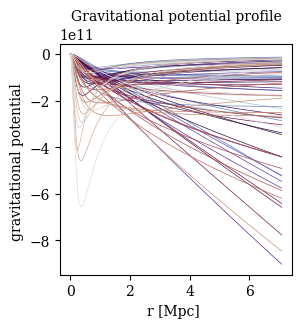

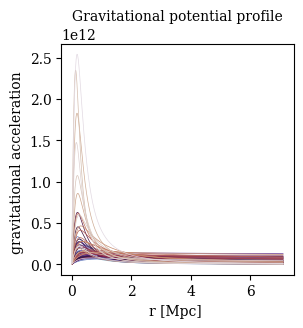

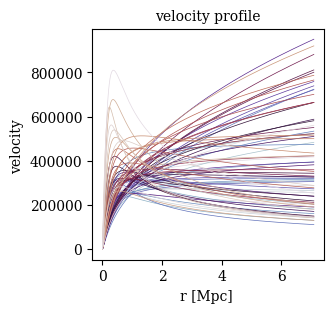

In [70]:
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))
m = np.zeros(shape=(len(R),len(r))) # for mass profile
u = np.zeros(shape=(len(R),len(r))) # for density profile
p = np.zeros(shape=(len(R),len(r))) # for radius
gravpot = np.zeros(shape=(len(R),len(r))) # for gravitational potential
accel = np.zeros(shape=(len(R),len(r)))
velocity = np.zeros(shape=(len(R),len(r)))
g_newton = np.zeros(shape=(len(R),len(r)))

for i in range(len(R)):
  rr = 0.25
  for j in range(len(r)):
    p[i][j] = np.log10(r[j]/rr)
    m[i][j] = np.log10(Massa_r[i][j])
    u[i][j] = np.log10(density_r_cluster_astro_tot[i][j]/rho_0_astro_units[i])
    gravpot[i][j] = phi[i][j]
    accel[i][j] = -gravpot[i][j]/(r[j])
    velocity[i][j] = np.sqrt(accel[i][j]*r[j])
    g_newton[i][j] = (G_PC_SM_KM_S*Massa_r[i][j]*Massa_r[i][j])/(R_500[i]*R_500[i])

fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))
ax.set_title("Gravitational potential profile", fontsize=10)
ax.set_xlabel(r"r [Mpc] ", fontsize=10)
ax.set_ylabel(r"gravitational potential ", fontsize=10)
for i in range(len(R)):
  ax.plot(r,gravpot[i], color=colors[i], linewidth=0.5)
plt.show()
##########
fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))
ax.set_title("Gravitational potential profile", fontsize=10)
ax.set_xlabel(r"r [Mpc] ", fontsize=10)
ax.set_ylabel(r"gravitational acceleration ", fontsize=10)
for i in range(len(R)):
  ax.plot(r,accel[i], color=colors[i], linewidth=0.5) 
plt.show() 
##########
fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))
ax.set_title("velocity profile", fontsize=10)
ax.set_xlabel(r"r [Mpc] ", fontsize=10)
ax.set_ylabel(r"velocity ", fontsize=10)
for i in range(len(R)):
  ax.plot(r,velocity[i], color=colors[i], linewidth=0.5)
plt.show()
##########

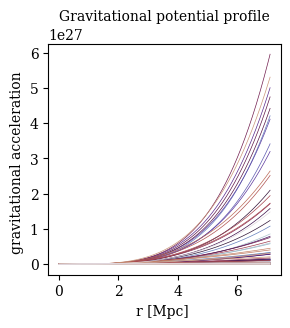

In [71]:
fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))
ax.set_title("Gravitational potential profile", fontsize=10)
ax.set_xlabel(r"r [Mpc] ", fontsize=10)
ax.set_ylabel(r"gravitational acceleration ", fontsize=10)
for i in range(len(R)):
  ax.plot(r,accel[i], color=colors[i], linewidth=0.5) 
for i in range(len(R)):
  ax.plot(r,g_newton[i], color=colors[i], linewidth=0.5) 
plt.show() 
##########

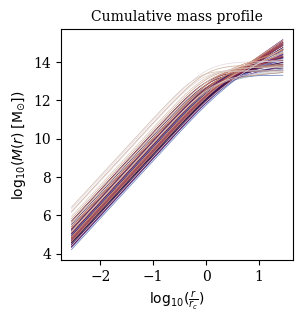

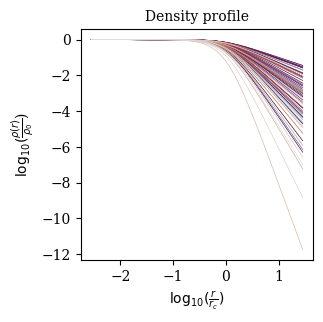

In [72]:
fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))
ax.set_title("Cumulative mass profile", fontsize=10)
ax.set_xlabel(r"$\mathrm{log}_{10}(\frac{r}{r_c})$ ", fontsize=10)
ax.set_ylabel(r"$\mathrm{log}_{10}(M(r) \; [\mathrm{M_{\odot}}])$ ", fontsize=10)
for i in range(len(R)):
  ax.plot(np.log10(r/r_scale),m[i], color=colors[i], linewidth=0.5)
if (w == 1.0):
  plt.savefig(profiles + 'mass_profile.png', bbox_inches='tight') 
plt.show()
################
fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
colors = plt.cm.twilight(np.linspace(0, 1, len(R)))

ax.set_title("Density profile", fontsize=10)
ax.set_xlabel(r"$\mathrm{log}_{10}(\frac{r}{r_c})$ ", fontsize=10)
ax.set_ylabel(r"$\mathrm{log}_{10}(\frac{\rho(r)}{\rho_{0}}$)", fontsize=10)
for i in range(len(R)):
  ax.plot(p[i],u[i], color=colors[i], linewidth=0.5)
if (w == 1.0):
  plt.savefig(profiles + 'mass_density_profile.png', bbox_inches='tight') 
plt.show()

In [73]:
density_500 = rho_0_astro_units*(1+((R*R)/(r_scale*r_scale)))**(-1.5*beta) #using a beta-model, i obtain the value of density at R=R_500, 
density_500_SI_units = (density_500*(M_S*1e3))/(PC*PC*PC*1e6)
density_500_SI_units_log_10 = np.log10(density_500_SI_units)
print("MASS DENSITY AT R = R_500 FOR EACH CLUSTER")
print(density_500_SI_units_log_10)
print("IN UNITS OF log10(g/cm3)")

MASS DENSITY AT R = R_500 FOR EACH CLUSTER
[-27.977126   -27.8250107  -27.88522475 -27.9105878  -28.11134593
 -27.91130097 -27.75167304 -27.75353096 -28.09475418 -27.74041629
 -28.1062489  -27.8626057  -28.10165724 -27.76458983 -27.84371314
 -28.05519915 -27.78440655 -27.72271247 -27.6941974  -28.28920594
 -27.84311075 -27.84224218 -27.68128985 -27.92564076 -27.84031724
 -27.63715643 -27.64312136 -27.78291241 -27.5985157  -27.99924729
 -27.99619964 -27.80231059 -27.70890854 -28.10681653 -27.70423629
 -27.86331457 -28.04554843 -27.69569057 -27.66975673 -27.92774489
 -28.33909975 -27.81291125 -28.45012266 -27.64666105 -27.62203418
 -27.70881034 -27.61070188 -27.83523554 -27.6413538  -28.00755824
 -27.79933013 -27.76345661 -27.69992525 -27.6101395  -27.63321715
 -27.61541566 -27.8965617  -27.92733853 -27.57572659 -28.19558234
 -27.73174483 -27.72286527 -27.79685113 -27.54713445 -28.16207114
 -28.36803696 -28.8012728  -27.75109198 -30.15206409 -28.51568729
 -28.02418511 -29.1143849  -28.12

In [74]:
print("SETTING THE X AND Y VALUES: X IS THE CIRCULAR VELOCITY OBTAINED BY MULTIPLYING THE VELOCITY DISPERSION \n FOR SQRT(3); Y IS THE BARYONIC MASS OBTAINED WITH THE EQUATION FUNCTION OF LUMINOSITY, RADIUS ecc.")
vel = np.sqrt(3)*v_disp
sigma_vel = np.sqrt(3)*sigma_v_disp

v = np.log10(vel)
error_v = sigma_vel/(vel*np.log(10))
if (ANALYSIS == 0):
  Mass = np.log10(w*Mass_SM)
  error_Mass = (sigma_Mass_SM)/(Mass_SM*np.log(10))
elif (ANALYSIS == 1):
  Mass = np.log10(probed_mass)
  error_Mass = rel_err_mass/(np.log(10))
  #error_Mass = mean_error_mass_formula/(np.log(10))

SETTING THE X AND Y VALUES: X IS THE CIRCULAR VELOCITY OBTAINED BY MULTIPLYING THE VELOCITY DISPERSION 
 FOR SQRT(3); Y IS THE BARYONIC MASS OBTAINED WITH THE EQUATION FUNCTION OF LUMINOSITY, RADIUS ecc.


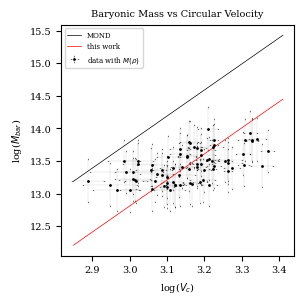

In [75]:
if (ANALYSIS == 0):
  label_mass = "data with $M_{500}$"
elif (ANALYSIS == 1):
  label_mass = "data with $M(\\rho)$"

fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
ax.set_title("Baryonic Mass vs Circular Velocity", 
             fontsize=7)
ax.set_xlabel("log($V_{c}$)", 
              fontsize=7)
ax.set_ylabel("log($M_{bar}$)", 
              fontsize=7)
ax.tick_params(axis='both', 
               labelsize=7)
ax.errorbar(v,Mass,
            error_Mass,
            error_v,
            linestyle="None", 
            linewidth=0.05, 
            marker="o",
            markersize="1", 
            color="black", 
            capsize=0.2,
            label=label_mass)
points = np.linspace(2.85,3.41,1000)
ax.plot(points,1.79+4*points, color="black", label="MOND", linewidth=0.5)
ax.plot(points,0.81+4*points, color="red", label="this work", linewidth=0.5)

ax.legend(loc="upper left", 
          prop={"size":5})
if (w == 1.0):
  plt.savefig(cornerplots + 'Mbar_vs_Vc_with_mass_value.png', bbox_inches='tight') 
plt.show()


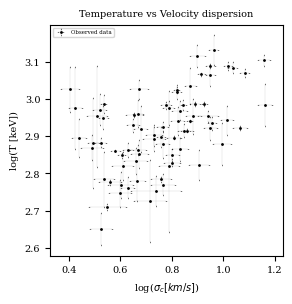

In [76]:
Temp = np.log10(T)
err_Temp = sigma_T/(T*np.log(10))

fig, ax = plt.subplots(figsize=(3,3), 
                       dpi=DPI)
ax.set_title("Temperature vs Velocity dispersion", 
             fontsize=7)
ax.set_xlabel("log($\sigma_{c} [km/s]$)", 
              fontsize=7)
ax.set_ylabel("log(T [keV])", 
              fontsize=7)
ax.tick_params(axis='both', 
               labelsize=7)
ax.errorbar(Temp,np.log10(v_disp),
            err_Temp,
            sigma_v_disp/(v_disp*np.log(10)),
            linestyle="None", 
            linewidth=0.05, 
            marker="o", 
            markersize = 1,
            color="black", 
            capsize=0.2,
            label="Observed data")
ax.legend(loc="upper left", 
          prop={"size":4})
if (w == 1.0):
  plt.savefig(mass_vs_velocity + 'T_v_disp.png', bbox_inches='tight') 
plt.show()

In [77]:
path_titos = str(PROJECT_ROOT / "in" / "data_clusters_general" / "data_titos" / "")
velocities_titos = loadtxt(path_titos+'/velocities_titos.txt')
v_titos = np.log10(velocities_titos)
masses_titos = loadtxt(path_titos+'/masses_titos.txt')
m_titos = np.log10(masses_titos)
#velocities_others = loadtxt("/Users/anvi/Desktop/my_projects/coding/algoritmi_magistrale/codice_tesi/data_report/velocities_other_clusters.txt")
#masses_others = loadtxt("/Users/anvi/Desktop/my_projects/coding/algoritmi_magistrale/codice_tesi/data_report/masses_other_clusters.txt")

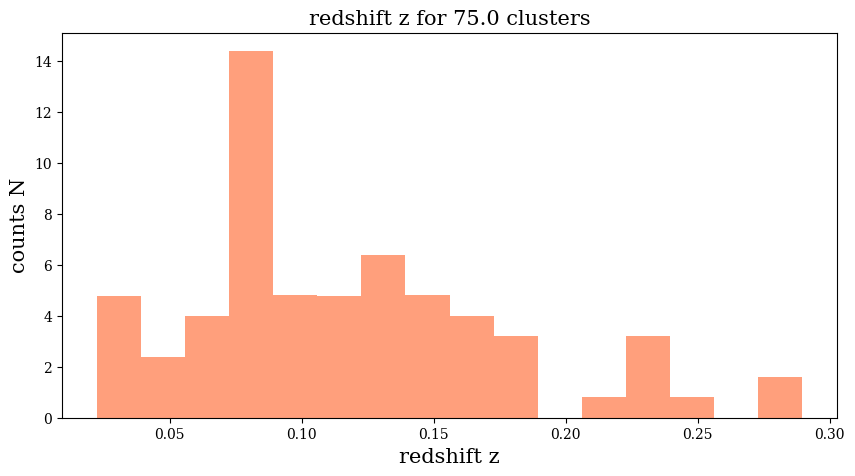

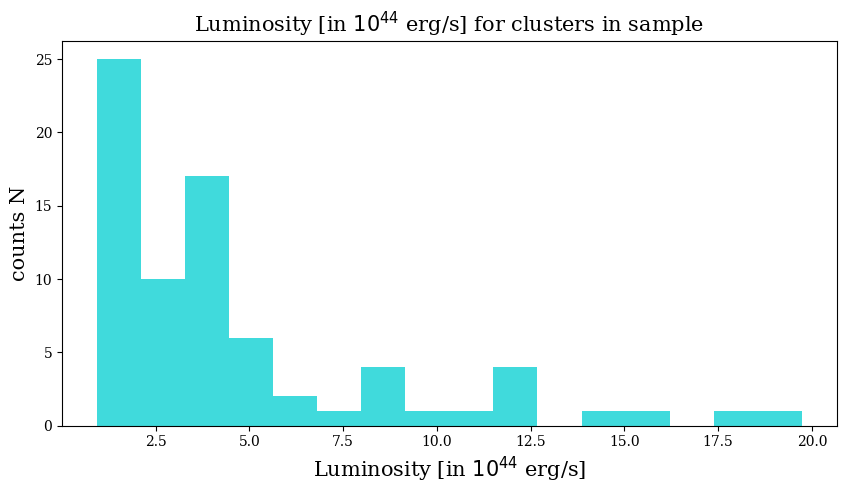

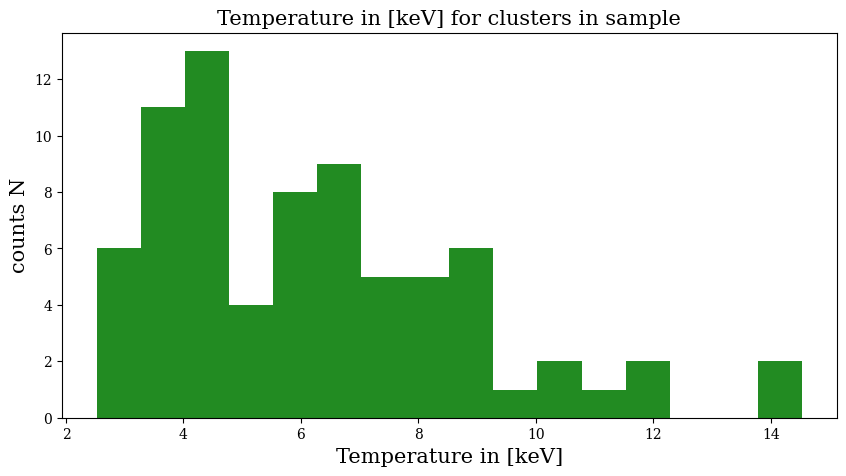

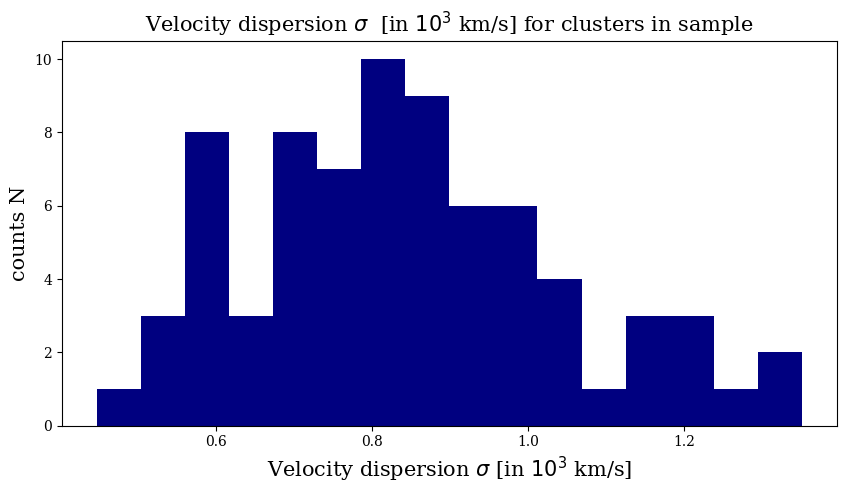

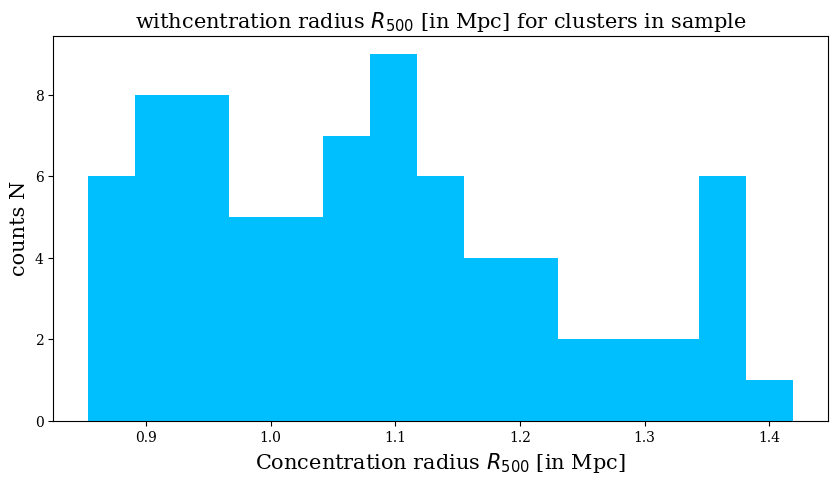

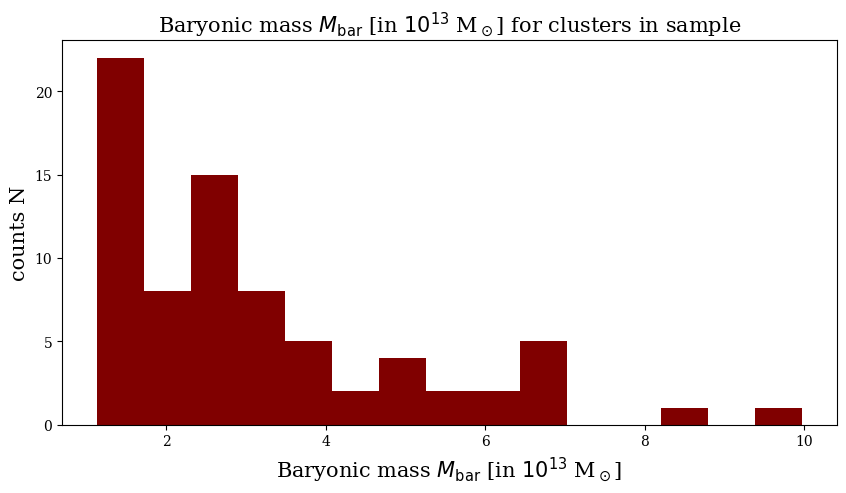

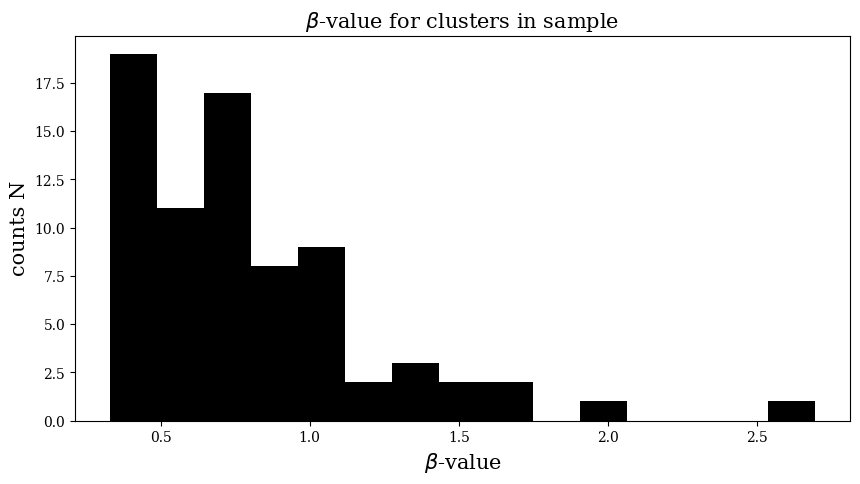

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
ax.hist(z, 16, density=True, histtype='stepfilled', facecolor='coral', alpha=0.75)
ax.set_title(f'redshift z for {N_CLUSTERS} clusters', fontsize = 15)
ax.set_xlabel("redshift z", 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_redshift_75_clusters.png', bbox_inches='tight') 
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
#ax.hist(L, 16, density=True, histtype='stepfilled', facecolor='darkturquoise', alpha=0.75)
ax.hist(L,16, histtype='stepfilled', facecolor='darkturquoise', alpha=0.75)
ax.set_title('Luminosity [in $10^{44}$ erg/s] for clusters in sample', fontsize = 15)
ax.set_xlabel("Luminosity [in $10^{44}$ erg/s]", 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_luminosity_75_clusters.png', bbox_inches='tight') 
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
ax.hist(T, 16, density=False, histtype='stepfilled', facecolor='forestgreen', rwidth=0.8)
ax.set_title(f'Temperature in [keV] for clusters in sample', fontsize = 15)
ax.set_xlabel("Temperature in [keV]", 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_temperature_75_clusters.png', bbox_inches='tight') 
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
ax.hist(v_disp/(1e3), 16, density=False, histtype='stepfilled', facecolor='navy', rwidth=0.8)
ax.set_title(f'Velocity dispersion ' fr'$\sigma$  [in $10^3$ km/s] for clusters in sample', fontsize = 15)
ax.set_xlabel('Velocity dispersion ' fr'$\sigma$ [in $10^3$ km/s]', 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_velocity_dispersion_75_clusters.png', bbox_inches='tight') 
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
ax.hist(R, 15, density=False, histtype='stepfilled', facecolor='deepskyblue', rwidth=0.8)
ax.set_title('withcentration radius $R_{500}$ [in Mpc] for clusters in sample', fontsize = 15)
ax.set_xlabel('Concentration radius $R_{500}$ [in Mpc]', 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_radius_500_75_clusters.png', bbox_inches='tight') 
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
ax.hist(Mass_SM/(1e13), 15, density=False, histtype='stepfilled', facecolor='maroon', rwidth=0.8)
ax.set_title(r'Baryonic mass $M_{\mathrm{bar}}$ [in $10^{13}$ M$_\odot$] for clusters in sample', fontsize = 15)
ax.set_xlabel(r'Baryonic mass $M_{\mathrm{bar}}$ [in $10^{13}$ M$_\odot$]', 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_Mbar_75_clusters.png', bbox_inches='tight')
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi = DPI)
ax.hist(beta, 15, density=False, histtype='stepfilled', facecolor='black', rwidth=0.8)
ax.set_title(r'$\beta$-value for clusters in sample', fontsize = 15)
ax.set_xlabel(r'$\beta$-value', 
              fontsize=15)
ax.set_ylabel("counts N", 
              fontsize=15)
if (w == 1.0):
  plt.savefig(cornerplots + 'histogram_beta_75_clusters.png', bbox_inches='tight')

In [79]:
print("SETTING THE X AND Y ARRAYS FOR THE MCMC")
X = v
Y = Mass
X_err = error_v
Y_err = error_Mass
error = (X_err*X_err+Y_err*Y_err)**0.5

SETTING THE X AND Y ARRAYS FOR THE MCMC


In [80]:
print("NWALKERS = ", nwalkers)
print("NITERATIONS = ", niter)
print("NBURNIN = ", nburnin)

NWALKERS =  100
NITERATIONS =  10000
NBURNIN =  100


MCMC TIMES

In [81]:
B_MOND = constants_dict['Value'][1]
Gb = G_PC_SM_KM_S*B_MOND*PC*1e-6
a = np.log10(Gb)
print(Gb)

0.01592549179240903


START OF MCMC ANALYSIS
Running burn-in...


100%|██████████| 100/100 [00:00<00:00, 889.20it/s]

Running iterations...



100%|██████████| 10000/10000 [00:09<00:00, 1021.27it/s]


STATISTICS: CHI-SQUARED AND P-VALUE
CHI-SQUARED VALUE: 68.05740958811694
NUMBER OF DOF =  73
REDUCED CHI-SQUARED: 0.9322932820289992
P_VALUE =  0.6417496800714249
CONVERGENCE AND CORRELATION: AUTOCORRELATION TIME
46.93974197111767 is the autocorrelation time for the parameter 0
51.28807173613628 is the autocorrelation time for the parameter 1
CONVERGENCE AND CORRELATION: CHAINS
CONVERGENCE AND CORRELATION: AUTOCORRELATION TIME


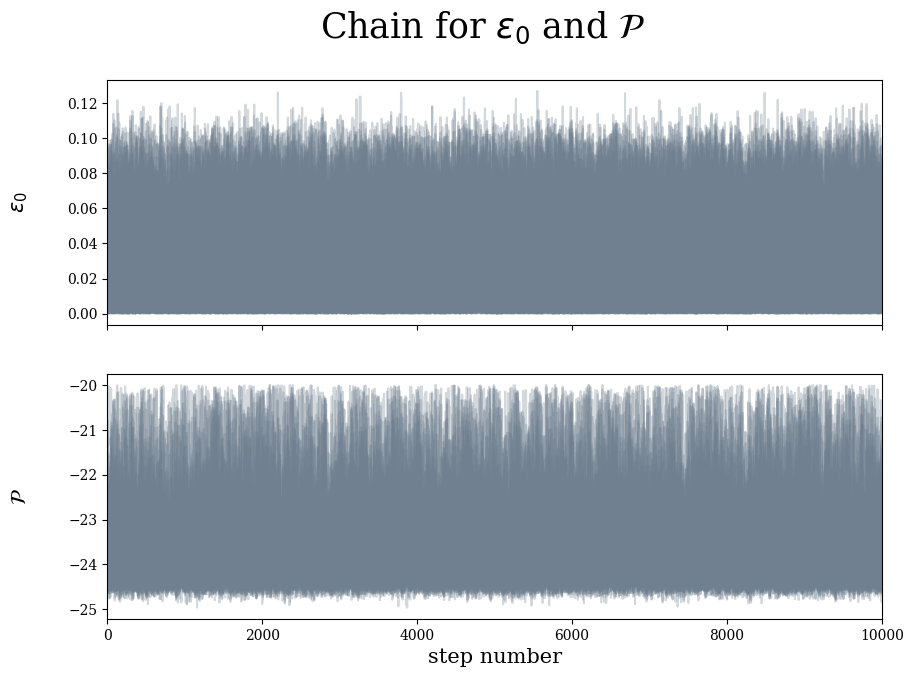

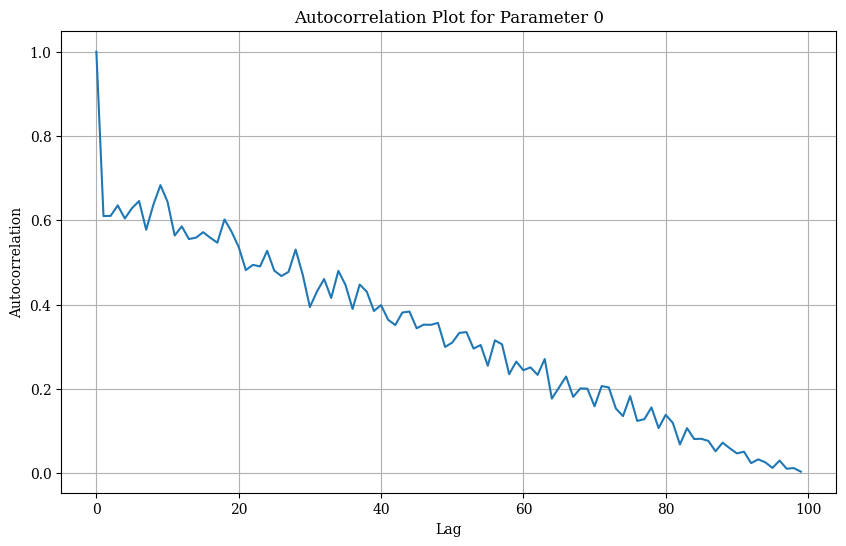

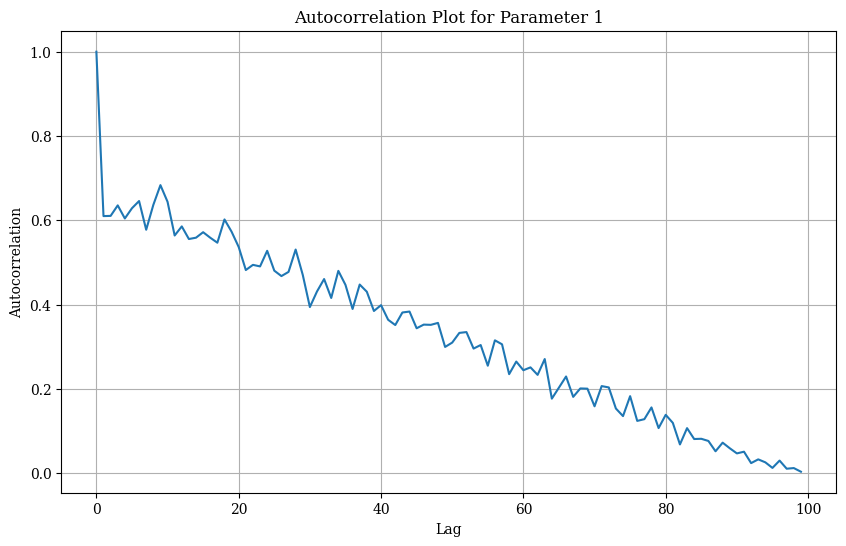

CONVERGENCE AND CORRELATION: INTEGRATED AUTOCORRELATION TIME


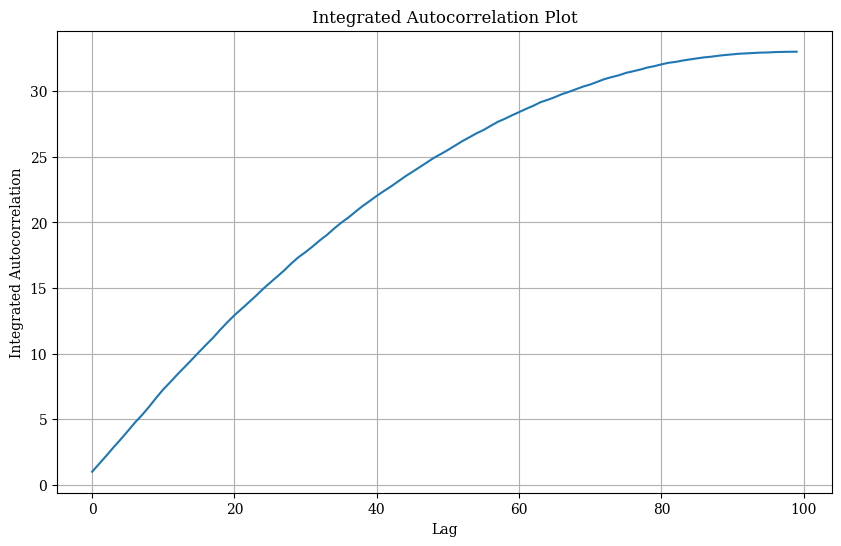

GELMAN-RUBIN TEST for parameter 0  = 0.9950377197707964
GELMAN-RUBIN TEST for parameter 1  = 0.9950373630739501
CONTOUR PLOTS TIME
Removed no burn in


<Figure size 600x450 with 0 Axes>

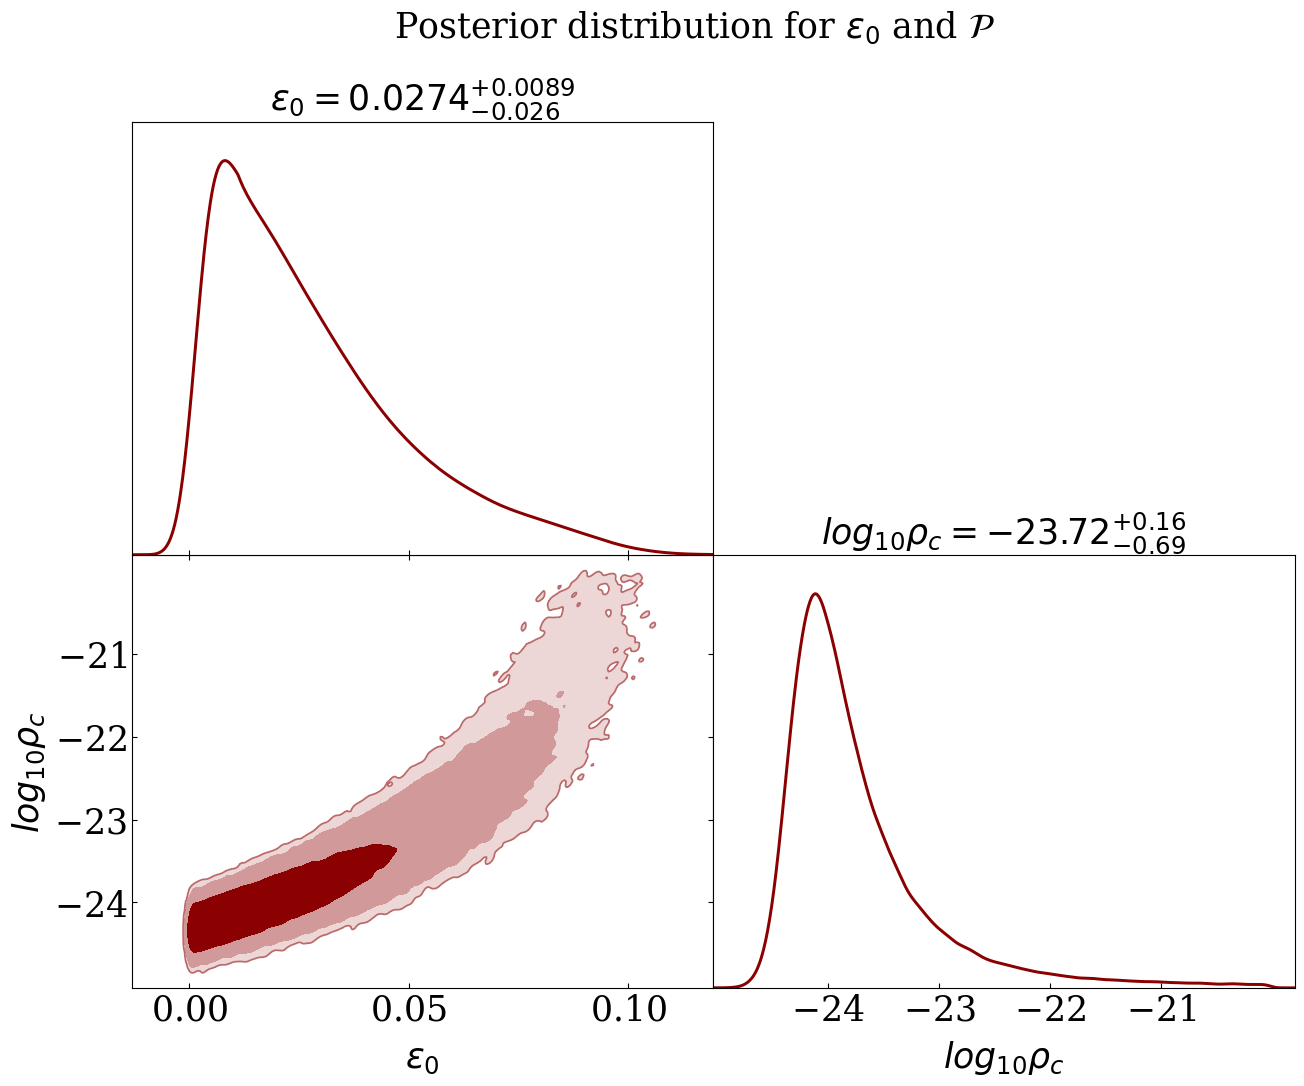

In [82]:

#############
if (ANALYSIS == 0):
        if (NPARAMS == 2):
            def model(theta,X=X):
                ep, B = theta
                return np.log10(ep) - a + B*X 
        elif (NPARAMS == 1):
            def model(theta,X=X):
                ep = theta
                return np.log10(ep) - a + 4*X
elif (ANALYSIS == 1):
        if (NPARAMS == 2):
            def model(theta,X=X):
                e0, P_density = theta
                Q_scelto = (Ell_Q+Disk_Q)*0.5
                return np.log10(e0+0.5*(1-e0)*(np.tanh((Q_scelto/np.log(10))*(density_500_SI_units_log_10-P_density))+1)) - a + 4*X
        elif (NPARAMS == 3):
            def model(theta,X=X):
                ep, P_density, Q = theta
                return np.log10(ep+0.5*(1-ep)*(np.tanh((Q/np.log(10))*(density_500_SI_units_log_10-P_density))+1)) - a + 4.0*X 
        elif (NPARAMS == 4):
            def model(theta,X=X):
                ep, P_density, Q, B = theta
                return np.log10(ep+0.5*(1-ep)*(np.tanh((Q/np.log(10))*(density_500_SI_units_log_10-P_density))+1)) - a + B*X 
#############
#############
def lnlike(theta, X, Y, error):
    return -0.5 * np.sum(((Y - model(theta, X))/error) ** 2)
#############  
#############
def lnprior(theta):
    if (ANALYSIS == 0):
        if (NPARAMS == 2):
            ep, B = theta
            if ((0.00 < ep < 1.0) and (3.0 < B < 5.0)):
                return 0.0
            return -np.inf
        elif (NPARAMS == 1):
            ep = theta
            if (0.00 < ep < 1.0):
                return 0.0
            return -np.inf
    elif (ANALYSIS == 1):
        if (NPARAMS == 2):
            e0, P_density = theta
            if ((0.0 < e0 < 1.0) and (-27.00 < P_density < -20.0)):
                return 0.0
            return -np.inf
        elif (NPARAMS == 3):
            ep, crit_dens, Q = theta
            if ((0.00 < ep < 1.0) and (-27 < crit_dens < -24) and (0.01 < Q < 2.0)):
                return 0.0
            return -np.inf
        elif (NPARAMS == 4):
            ep, P_density, Q, B = theta
            if ((0.00 < ep < 1.0) and (-27 < P_density < -24) and (0.01 < Q < 2.0) and (3.0 < B < 5.0)):
                return 0.0
            return -np.inf
#############
#############
def lnprob(theta, X, Y, error):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, X, Y, error)
#############
#data
data = (X,Y,error)
if (ANALYSIS == 0):
  if (NPARAMS == 2):
    initial = np.array([0.15, 4.0])
  elif (NPARAMS == 1):
    initial = np.array([0.15])
elif (ANALYSIS == 1):
  if (NPARAMS == 2):
    initial = np.array([0.15, -25.0])
  elif (NPARAMS == 3):
    initial = np.array([0.15, -25.0, 1.0])
  elif (NPARAMS == 4):
    initial = np.array([0.150, -25.0, 1.0, 4.0])
ndim = len(initial) #il numero di dimensioni dello spazio dei parametri
dof = len(Y) - ndim
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
#############
#############
def chi_square(parameters, X, Y, error):
    predicted = model(parameters, X)
    return np.sum(((Y - predicted) / error) ** 2)
#############
print("START OF MCMC ANALYSIS")
def main(p0,nwalkers,niter,ndim,lnprob,data):

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    # lnprob è una funzione che prende un vettore nello spazio dei parametri come input e ritorna il logaritmo natuare della probabilità posterior in quella posizione.
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, nburnin, progress=True)
    # sample.run_mcmc itera il sampler (sample()) per nsteps = nburnin e restituisce il risultato
    sampler.reset() #questo resetta i parametri alla scelta dei parametri iniziali

    print("Running iterations...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)
    # sample.run_mcmc itera il sampler (sample()) per nsteps = niter e restituisce il risultato

    return sampler, pos, prob, state
##########
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]
best_fit_parameters = samples[np.argmax(sampler.flatlnprobability)]
print("STATISTICS: CHI-SQUARED AND P-VALUE")
##########
chi_squared = chi_square(best_fit_parameters, X, Y, error)
print("CHI-SQUARED VALUE:", chi_squared)
print("NUMBER OF DOF = ", dof)
print("REDUCED CHI-SQUARED:", chi_squared/(dof))
p_value = 1 - stats.chi2.cdf(chi_squared, dof)
print("P_VALUE = ", p_value)
##########
print("CONVERGENCE AND CORRELATION: AUTOCORRELATION TIME")
tau = sampler.get_autocorr_time()
for i in range(ndim):
    print(tau[i], "is the autocorrelation time for the parameter", i)
##########
print("CONVERGENCE AND CORRELATION: CHAINS")
if (ndim > 1):
  fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
elif (ndim == 1):
  fig, ax = plt.subplots(ndim, figsize=(10, 7), sharex=True)
  
# Choose MCMC plot output folder based on w
mcmc_plot_dir = Path(cornerplots_100 if w == 1.0 else cornerplots_130)
mcmc_plot_dir.mkdir(parents=True, exist_ok=True)

samples = sampler.get_chain()
if (ANALYSIS == 0):
  if (NPARAMS == 2):
    labels = [r'$\epsilon_{0}$', 
             r'$\alpha$']
  elif (NPARAMS == 1):
    labels = [r'$\epsilon_{0}$']
elif (ANALYSIS == 1):
  if (NPARAMS == 2):
    labels = [r'$\epsilon_{0}$',
              r'$\mathcal{P}$']
  elif (NPARAMS == 3):
    labels = [r'$\epsilon_{0}$', 
             r'$\mathcal{P}$', 
             r'$Q$']  
  elif (NPARAMS == 4):
    labels = [r'$\epsilon_{0}$', 
             r'$\mathcal{P}$', 
             r'$Q$', 
             r'$\alpha$']
if (ndim > 1):
  for i in range(ndim):
      ax = axes[i]
      ax.plot(samples[:, :, i], color=color_chain, alpha=0.3)
      ax.set_xlim(0, len(samples))
      ax.set_ylabel(labels[i], fontsize=15)  # Imposta la dimensione dei label sull'asse y
      ax.yaxis.set_label_coords(-0.1, 0.5)
      ax.tick_params(axis='both', which='major', labelsize=10)  # Imposta la dimensione dei tick sugli assi
      axes[-1].set_xlabel("step number", fontsize=12)  # Imposta la dimensione del label sull'asse x
      axes[-1].tick_params(axis='both', which='major', labelsize=10)  # Imposta la dimensione dei tick sull'asse x
      axes[-1].set_xlabel("step number", fontsize=15)               
elif (ndim == 1):
  for i in range(ndim):
    ax.plot(samples[:, :, i], color=color_chain, alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=15)  # Imposta la dimensione dei label sull'asse y
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Imposta la dimensione dei tick sugli assi
    ax.set_xlabel("step number", fontsize=12)  # Imposta la dimensione del label sull'asse x
    ax.tick_params(axis='both', which='major', labelsize=10)  # Imposta la dimensione dei tick sull'asse x
    ax.set_xlabel("step number", fontsize=15)              
if (ANALYSIS == 0):
  if (NPARAMS == 2):
    plt.suptitle("Chain for $\epsilon_{0}$ and $\\alpha$", fontsize=25)
  elif (NPARAMS == 1):
    plt.suptitle("Chain for $\epsilon_{0}$", fontsize=25)
elif (ANALYSIS == 1):
  if (NPARAMS == 2):
    plt.suptitle(r'Chain for $\epsilon_{0}$ and $\mathcal{P}$', fontsize=25)
  elif (NPARAMS == 3):
    plt.suptitle(r'Chain for $\epsilon_{0}$, $\mathcal{P}$ and Q', fontsize=25)
  elif (NPARAMS == 4):
    plt.suptitle(r'Chain for $\epsilon_{0}$, $\mathcal{P}$, Q and $\alpha$', fontsize=25)
fig.savefig(mcmc_plot_dir / f"mcmc_chains_{N_CLUSTERS}_clusters.png", bbox_inches='tight')
    
print("CONVERGENCE AND CORRELATION: AUTOCORRELATION TIME")

def plot_autocorrelation(chain, parameter_index, save_path=None):
    autocorr = np.correlate(chain, chain, mode='full')
    autocorr = autocorr / np.max(autocorr)
    
    fig = plt.figure(figsize=(10, 6))
    plt.plot(autocorr[len(autocorr)//2:])
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Plot for Parameter {}'.format(parameter_index))
    plt.grid(True)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

chain = samples[0,:,0]

for i in range(ndim):
    plot_autocorrelation(chain, i, save_path=mcmc_plot_dir / f"autocorr_param_{i}_{N_CLUSTERS}_clusters.png")
    
print("CONVERGENCE AND CORRELATION: INTEGRATED AUTOCORRELATION TIME")

def integrated_autocorrelation(chain):
    autocorr = np.correlate(chain, chain, mode='full')
    autocorr = autocorr / np.max(autocorr)
    return np.cumsum(autocorr[len(autocorr)//2:])
def plot_integrated_autocorrelation(chain, save_path=None):
    iacf = integrated_autocorrelation(chain)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(iacf)
    plt.xlabel('Lag')
    plt.ylabel('Integrated Autocorrelation')
    plt.title('Integrated Autocorrelation Plot')
    plt.grid(True)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
    plt.show()

chain = samples[0,:,0]
plot_integrated_autocorrelation(chain, save_path=mcmc_plot_dir / f"integrated_autocorr_{N_CLUSTERS}_clusters.png")

def gelman_rubin(chains):
    nwalkers, nsteps, ndim = chains.shape
    means = np.mean(chains, axis=1)
    variances = np.var(chains, axis=1, ddof=1)    
    mean_means = np.mean(means, axis=0)
    between_chain_variance = nsteps / (nwalkers - 1) * np.sum((means - mean_means)**2, axis=0)
    within_chain_variance = np.mean(variances, axis=0)
    scale_factor = (nsteps - 1) / nsteps + (between_chain_variance / within_chain_variance) * (1 / nwalkers)
    return np.sqrt(scale_factor)

samples = sampler.get_chain()
for i in range(ndim):
    R_hat = gelman_rubin(samples)
    print("GELMAN-RUBIN TEST for parameter",i," =", R_hat[i])

print("CONTOUR PLOTS TIME")

g = plots.get_single_plotter()
if (ANALYSIS == 0):
  if (NPARAMS == 2):
    names_MCS = [r'\epsilon_{0}',
                 r'\alpha']
    labels_MCS = [r'\epsilon_{0}', 
                  r'\alpha']
  elif (NPARAMS == 1):
    names_MCS = [r'\epsilon_{0}']
    labels_MCS = [r'\epsilon_{0}']
elif (ANALYSIS == 1):
  if (NPARAMS == 2):
    names_MCS = [r'\epsilon_{0}', 
             r'log_{10}\rho_{c}']
    labels_MCS = [r'\epsilon_{0}', 
             r'log_{10}\rho_{c}']
  elif (NPARAMS == 3):
    names_MCS = [r'\epsilon_{0}', 
             r'log_{10}\rho_{c}', 
             r'Q']
    labels_MCS = [r'\epsilon_{0}', 
             r'log_{10}\rho_{c}', 
             r'Q']
  elif (NPARAMS == 4):
    names_MCS = [r'\epsilon_{0}', 
             r'log_{10}\rho_{c}', 
             r'Q', 
             r'\alpha']
    labels_MCS = [r'\epsilon_{0}', 
             r'log_{10}\rho_{c}', 
             r'Q', 
             r'\alpha']
samples_gd = MCSamples(samples=samples, 
                       names=names_MCS, 
                       labels=labels_MCS)
g.settings.axes_labelsize = 25
g.settings.fig_width_inch = 15
g.settings.fontsize = 25
g.settings.line_labels = True
g.settings.axis_tick_max_labels = 25
g.settings.title_limit_fontsize = 25
g.settings.num_plot_contours = 3
g.settings.axes_fontsize = 25
g.triangle_plot(samples_gd, 
                filled=True, 
                line_labels=True, 
                progress=True,
                contour_colors=[color_cornerplot],
                title_limit=1,
                quantiles=[0.15865, 0.5, 0.84135] #0.15865 upper bound, 0.5 median, 0.84135 upper bound
                #quantiles=[0.0015,0.5,0.9985]
                )
if (ANALYSIS == 0):
  if (NPARAMS == 2):
    corner_name = f"posterior_distribution_eps_alpha_{N_CLUSTERS}_clusters.png"
    plt.suptitle("Posterior distribution for $\epsilon_{0}$ and $\\alpha$", fontsize=25)
  elif (NPARAMS == 1):
    corner_name = f"posterior_distribution_eps_{N_CLUSTERS}_clusters.png"
    plt.suptitle("Posterior distribution for $\epsilon_{0}$", fontsize=25)
elif (ANALYSIS == 1):
  if (NPARAMS == 2):
    corner_name = f"posterior_distribution_eps_rhoc_{N_CLUSTERS}_clusters.png"
    plt.suptitle(r'Posterior distribution for $\epsilon_{0}$ and $\mathcal{P}$', fontsize=25)
  elif (NPARAMS == 3):
    corner_name = f"posterior_distribution_eps_rhoc_Q_{N_CLUSTERS}_clusters.png"
    plt.suptitle(r'Posterior distribution for $\epsilon_{0}$, $\mathcal{P}$ and Q', fontsize=25)
  elif (NPARAMS == 4):
    corner_name = f"posterior_distribution_eps_rhoc_Q_alpha_{N_CLUSTERS}_clusters.png"
    plt.suptitle(r'Posterior distribution for $\epsilon_{0}$, $\mathcal{P}$, Q and $\alpha$', fontsize=25)
plt.savefig(mcmc_plot_dir / corner_name, bbox_inches='tight')

In [83]:
if (ANALYSIS == 0):
  if (NPARAMS == 2):
    eps0_fin = np.mean(samples_gd[0])
    alpha_fin = np.mean(samples_gd[1])
    #comparison with Cesare et al 2022
    ########
    ########
    #first parameter
    M1 = eps0_fin
    N1 = Ell_eps0
    unc_M1_p = 0.22
    unc_M1_m = 0.075
    unc_N1_p = unc_Ell_eps0_p
    unc_N1_m = unc_Ell_eps0_m
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print(f'{names_MCS[0]} is away from the value in Cesare et al. 2022', Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #first parameter
    N1 = Disk_eps0
    unc_N1_p = unc_Disk_eps0
    unc_N1_m = unc_Disk_eps0
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print(f'{names_MCS[0]} is away from the value in Cesare et al. 2020', Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #second parameter
    M2 = alpha_fin
    N2 = slope_BTFR
    unc_M2_p = 0.015
    unc_M2_m = 0.045
    unc_N2_p = unc_slope_BTFR_p
    unc_N2_m = unc_slope_BTFR_m
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print(f'{names_MCS[1]} is away from the value of the BTFR slope', Delta_M_N2/Delta_unc_2, "sigma")
  elif (NPARAMS == 1):
    eps0_fin = np.mean(samples_gd[0])
    print(eps0_fin)
    #comparison with Cesare et al 2020
    ########
    ########
    #first parameter
    M1 = eps0_fin
    N1 = Ell_eps0
    unc_M1_p = 0.0081
    unc_M1_m = 0.0097
    unc_N1_p = unc_Ell_eps0_p
    unc_N1_m = unc_Ell_eps0_m
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon is away from the value in Cesare et al. 2022", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #first parameter
    N1 = Disk_eps0
    unc_N1_p = unc_Disk_eps0
    unc_N1_m = unc_Disk_eps0
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon is away from the value in Cesare et al. 2020", Delta_M_N1/Delta_unc_1, "sigma")
if (ANALYSIS == 1):
  if (NPARAMS == 4):
    eps0_fin = np.mean(samples_gd[0])
    rhoc_fin = np.mean(samples_gd[1])
    Q_fin = np.mean(samples_gd[2])
    alpha_fin = np.mean(samples_gd[3])
    #comparison with Cesare et al 2022
    ########
    ########
    #first parameter
    M1 = eps0_fin
    N1 = Ell_eps0
    unc_M1_p = 0.088
    unc_M1_m = 0.35
    unc_N1_p = unc_Ell_eps0_p
    unc_N1_m = unc_Ell_eps0_m
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon_0 is away from the value in Cesare et al. 2022", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #first parameter
    N1 = Disk_eps0
    unc_N1_p = unc_Disk_eps0
    unc_N1_m = unc_Disk_eps0
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon_0 is away from the value in Cesare et al. 2020", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #second parameter
    M2 = rhoc_fin
    N2 = Disk_rhoc
    unc_M2_p = 0.71
    unc_M2_m = 1.8
    unc_N2_p = unc_Disk_rhoc
    unc_N2_m = unc_Disk_rhoc
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print("rho_c is away from the value of the critical density in Cesare et al. 2020", Delta_M_N2/Delta_unc_2, "sigma")
    ########
    ########
    #second parameter
    N2 = Ell_rhoc
    unc_N2_p = unc_Ell_rhoc_p
    unc_N2_m = unc_Ell_rhoc_m
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print("rho_c is away from the value of the critical density in Cesare et al. 2022", Delta_M_N2/Delta_unc_2, "sigma")
    #comparison with Cesare et al 2022
    ########
    ########
    #third parameter
    M3 = Q_fin
    N3 = Ell_Q
    unc_M3_p = 0.67
    unc_M3_m = 0.26
    unc_N3_p = unc_Ell_Q_p
    unc_N3_m = unc_Ell_Q_m
    if (M3 > N3):
      delta_M3 = unc_M3_m
      delta_N3 = unc_N3_p
    else:
      delta_M3 = unc_M3_p
      delta_N3 = unc_N3_m
    #M-N
    Delta_M_N3 = np.abs(M3-N3)
    #Delta_M - Delta_N
    Delta_unc_3 = np.sqrt(delta_M3*delta_M3+delta_N3*delta_N3)
    print("Q is away from the value in Cesare et al. 2022", Delta_M_N3/Delta_unc_3, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #third parameter
    N3 = Disk_Q
    unc_N3_p = unc_Disk_Q
    unc_N3_m = unc_Disk_Q
    if (M3 > N3):
      delta_M3 = unc_M3_m
      delta_N3 = unc_N3_p
    else:
      delta_M3 = unc_M3_p
      delta_N3 = unc_N3_m
    #M-N
    Delta_M_N3 = np.abs(M3-N3)
    #Delta_M - Delta_N
    Delta_unc_3 = np.sqrt(delta_M3*delta_M3+delta_N3*delta_N3)
    print("Q is away from the value in Cesare et al. 2020", Delta_M_N3/Delta_unc_3, "sigma")
    ########
    ########
    #fourth parameter
    M4 = alpha_fin
    N4 = slope_BTFR
    unc_M4_p = 0.026
    unc_M4_m = 0.080
    unc_N4_p = unc_slope_BTFR_p
    unc_N4_m = unc_slope_BTFR_m
    if (M4 > N4):
      delta_M4 = unc_M4_m
      delta_N4 = unc_N4_p
    else:
      delta_M4 = unc_M4_p
      delta_N4 = unc_N4_m
    Delta_M_N4 = np.abs(M4-N4)
    Delta_unc_4 = np.sqrt(delta_M4*delta_M4+delta_N4*delta_N4)
    print("alpha is away from the value of the critical density in BTFR", Delta_M_N4/Delta_unc_4, "sigma")
    ########
    ########
  elif (NPARAMS == 3):
    eps0_fin = np.mean(samples_gd[0])
    rhoc_fin = np.mean(samples_gd[1])
    Q_fin = np.mean(samples_gd[2])
    #comparison with Cesare et al 2022
    ########
    ########
    #first parameter
    M1 = eps0_fin
    N1 = Ell_eps0
    unc_M1_p = 0.016
    unc_M1_m = 0.023
    unc_N1_p = unc_Ell_eps0_p
    unc_N1_m = unc_Ell_eps0_m
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon_0 is away from the value in Cesare et al. 2022", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #first parameter
    N1 = Disk_eps0
    unc_N1_p = unc_Disk_eps0
    unc_N1_m = unc_Disk_eps0
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon_0 is away from the value in Cesare et al. 2020", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #second parameter
    M2 = rhoc_fin
    N2 = Disk_rhoc
    unc_M2_p = 0.11
    unc_M2_m = 0.48
    unc_N2_p = unc_Disk_rhoc
    unc_N2_m = unc_Disk_rhoc
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print("rho_c is away from the value of the critical density in Cesare et al. 2020", Delta_M_N2/Delta_unc_2, "sigma")
    ########
    ########
    #second parameter
    N2 = Ell_rhoc
    unc_N2_p = unc_Ell_rhoc_p
    unc_N2_m = unc_Ell_rhoc_m
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print("rho_c is away from the value of the critical density in Cesare et al. 2022", Delta_M_N2/Delta_unc_2, "sigma")
    #comparison with Cesare et al 2022
    ########
    ########
    #third parameter
    M3 = Q_fin
    N3 = Ell_Q
    unc_M3_p = 0.38
    unc_M3_m = 0.12
    unc_N3_p = unc_Ell_Q_p
    unc_N3_m = unc_Ell_Q_m
    if (M3 > N3):
      delta_M3 = unc_M3_m
      delta_N3 = unc_N3_p
    else:
      delta_M3 = unc_M3_p
      delta_N3 = unc_N3_m
    #M-N
    Delta_M_N3 = np.abs(M3-N3)
    #Delta_M - Delta_N
    Delta_unc_3 = np.sqrt(delta_M3*delta_M3+delta_N3*delta_N3)
    print("Q is away from the value in Cesare et al. 2022", Delta_M_N3/Delta_unc_3, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #third parameter
    N3 = Disk_Q
    unc_N3_p = unc_Disk_Q
    unc_N3_m = unc_Disk_Q
    if (M3 > N3):
      delta_M3 = unc_M3_m
      delta_N3 = unc_N3_p
    else:
      delta_M3 = unc_M3_p
      delta_N3 = unc_N3_m
    #M-N
    Delta_M_N3 = np.abs(M3-N3)
    #Delta_M - Delta_N
    Delta_unc_3 = np.sqrt(delta_M3*delta_M3+delta_N3*delta_N3)
    print("Q is away from the value in Cesare et al. 2020", Delta_M_N3/Delta_unc_3, "sigma")
    ########
    ########
  elif (NPARAMS == 2):
    eps0_fin = np.mean(samples_gd[0])
    rhoc_fin = np.mean(samples_gd[1])
    #comparison with Cesare et al 2022
    ########
    ########
    #first parameter
    M1 = eps0_fin
    N1 = Ell_eps0
    unc_M1_p = 0.011
    unc_M1_m = 0.036
    unc_N1_p = unc_Ell_eps0_p
    unc_N1_m = unc_Ell_eps0_m
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon_0 is away from the value in Cesare et al. 2022", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #comparison with Cesare et al 2020
    ########
    ########
    #first parameter
    N1 = Disk_eps0
    unc_N1_p = unc_Disk_eps0
    unc_N1_m = unc_Disk_eps0
    if (M1 > N1):
      delta_M1 = unc_M1_m
      delta_N1 = unc_N1_p
    else:
      delta_M1 = unc_M1_p
      delta_N1 = unc_N1_m
    #M-N
    Delta_M_N1 = np.abs(M1-N1)
    #Delta_M - Delta_N
    Delta_unc_1 = np.sqrt(delta_M1*delta_M1+delta_N1*delta_N1)
    print("epsilon_0 is away from the value in Cesare et al. 2020", Delta_M_N1/Delta_unc_1, "sigma")
    ########
    ########
    #second parameter
    M2 = rhoc_fin
    N2 = Ell_rhoc
    unc_M2_p = 0.17
    unc_M2_m = 0.73
    unc_N2_p = unc_Ell_rhoc_p
    unc_N2_m = unc_Ell_rhoc_m
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print("rho_c is away from the value of the critical density in Cesare et al. 2022", Delta_M_N2/Delta_unc_2, "sigma")
    ########
    ########
    #second parameter
    N2 = Disk_rhoc
    unc_N2_p = unc_Disk_rhoc
    unc_N2_m = unc_Disk_rhoc
    if (M2 > N2):
      delta_M2 = unc_M2_m
      delta_N2 = unc_N2_p
    else:
      delta_M2 = unc_M2_p
      delta_N2 = unc_N2_m
    Delta_M_N2 = np.abs(M2-N2)
    Delta_unc_2 = np.sqrt(delta_M2*delta_M2+delta_N2*delta_N2)
    print("rho_c is away from the value of the critical density in Cesare et al. 2020", Delta_M_N2/Delta_unc_2, "sigma")

epsilon_0 is away from the value in Cesare et al. 2022 1.6785785243606803 sigma
epsilon_0 is away from the value in Cesare et al. 2020 3.3208079681140985 sigma
rho_c is away from the value of the critical density in Cesare et al. 2022 0.6724913409783959 sigma
rho_c is away from the value of the critical density in Cesare et al. 2020 1.1083667193162041 sigma


In [84]:
# LOG MCMC RESULTS TO RECAP FILE
mcmc_results = f"""MCMC ANALYSIS RESULTS:

Chi-Squared Statistics:
  Chi-squared value: {chi_squared:.4f}
  Degrees of freedom: {dof}
  Reduced chi-squared: {chi_squared/dof:.4f}
  P-value: {p_value:.6e}

Autocorrelation Times:"""

for i in range(ndim):
    mcmc_results += f"\n  Parameter {i}: {tau[i]:.4f}"

mcmc_results += "\n\nGelman-Rubin Statistics:"
for i in range(ndim):
    mcmc_results += f"\n  Parameter {i}: {R_hat[i]:.6f}"

mcmc_results += "\n\nBest-Fit Parameters:"
for i in range(len(best_fit_parameters)):
    mcmc_results += f"\n  Parameter {i}: {best_fit_parameters[i]:.6f}"

mcmc_results += "\n\nParameter Names and Mean Values:"
if (ANALYSIS == 0):
    if (NPARAMS == 2):
        mcmc_results += f"\n  ε₀ (vacuum permittivity): {eps0_fin:.6f}"
        mcmc_results += f"\n  α (BTFR slope): {alpha_fin:.6f}"
    elif (NPARAMS == 1):
        mcmc_results += f"\n  ε₀ (vacuum permittivity): {eps0_fin:.6f}"
elif (ANALYSIS == 1):
    if (NPARAMS == 2):
        mcmc_results += f"\n  ε₀ (vacuum permittivity): {eps0_fin:.6f}"
        mcmc_results += f"\n  log₁₀(ρ_c) (critical density): {rhoc_fin:.6f}"
    elif (NPARAMS == 3):
        mcmc_results += f"\n  ε₀ (vacuum permittivity): {eps0_fin:.6f}"
        mcmc_results += f"\n  log₁₀(ρ_c) (critical density): {rhoc_fin:.6f}"
        mcmc_results += f"\n  Q (steepness parameter): {Q_fin:.6f}"
    elif (NPARAMS == 4):
        mcmc_results += f"\n  ε₀ (vacuum permittivity): {eps0_fin:.6f}"
        mcmc_results += f"\n  log₁₀(ρ_c) (critical density): {rhoc_fin:.6f}"
        mcmc_results += f"\n  Q (steepness parameter): {Q_fin:.6f}"
        mcmc_results += f"\n  α (BTFR slope): {alpha_fin:.6f}"

log_result("MCMC RESULTS", mcmc_results)
print("MCMC results logged to recap file.")

MCMC results logged to recap file.


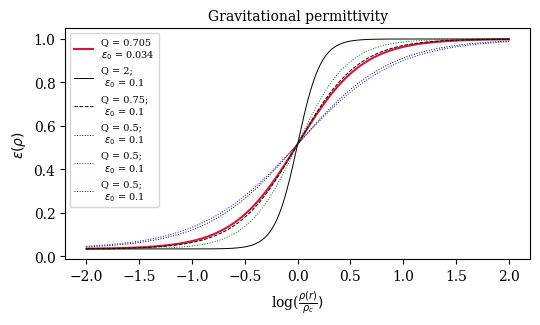

In [85]:
Q_plot_function = 0.705
epsilon_0_plot_function = 0.034
rho_c_plot_function = 10**(-26)
q_1 = 2
q_2 = 0.75
q_3 = 0.5
e0_1 = 0.1
ics = np.linspace(1e-28,1e-24,10000000)
e0_2020 = 0.56
Q_2020 =  0.92
e0_2022 = 0.089
Q_2022 = 0.47

def func(ics,epsilon_0_plot_function,Q_plot_function,rho_c_plot_function):
    #return epsilon_0_plot_function+0.5*(1-epsilon_0_plot_function)*(np.tanh((Q_plot_function/np.log(10))*(ics-rho_c_plot_function))+1)
    return 0.034 + (1-0.034)*0.5*(np.tanh(np.log((ics/rho_c_plot_function)**Q_plot_function))+1)
fig, ax = plt.subplots(figsize=(6,3), dpi=DPI)
ax.set_title("Gravitational permittivity", 
             fontsize=10)
ax.set_xlabel(r'log($\frac{\rho(r)}{\rho_c})$', 
              fontsize=10)
ax.set_ylabel(r'$\epsilon(\rho)$', 
              fontsize=10)
epsilon_rho = func(ics,epsilon_0_plot_function, Q_plot_function, rho_c_plot_function)
plt.plot(np.log10((ics/(rho_c_plot_function))), 
         epsilon_rho, 
         label=r'Q = {:.4g};$\epsilon_0$ = {:.2g}'.format(Q_plot_function, epsilon_0_plot_function).replace(';', '\n'), 
         color='crimson')
plt.plot(np.log10((ics/(rho_c_plot_function))), 
         func(ics,e0_1, q_1, rho_c_plot_function), 
         label=r'Q = {:.4g}; $\epsilon_0$ = {:.2g}'.format(q_1, e0_1).replace(';', ';\n'), 
         color='black', 
         linewidth = 0.7)
plt.plot(np.log10((ics/(rho_c_plot_function))), 
         func(ics,e0_1, q_2, rho_c_plot_function), 
         label=r'Q = {:.4g}; $\epsilon_0$ = {:.2g}'.format(q_2, e0_1).replace(';', ';\n'), 
         color='black', 
         linestyle='dashed', 
         linewidth = 0.7)
plt.plot(np.log10((ics/(rho_c_plot_function))), 
         func(ics,e0_1, q_3, rho_c_plot_function), 
         label=r'Q = {:.4g}; $\epsilon_0$ = {:.2g}'.format(q_3, e0_1).replace(';', ';\n'), 
         color='black', 
         linestyle='dotted', 
         linewidth = 0.7)
plt.plot(np.log10((ics/(rho_c_plot_function))), 
         func(ics,e0_2020, Q_2020, rho_c_plot_function), 
         label=r'Q = {:.4g}; $\epsilon_0$ = {:.2g}'.format(q_3, e0_1).replace(';', ';\n'), 
         color='green', 
         linestyle='dotted', 
         linewidth = 0.7)
plt.plot(np.log10((ics/(rho_c_plot_function))), 
         func(ics,e0_2022, Q_2022, rho_c_plot_function), 
         label=r'Q = {:.4g}; $\epsilon_0$ = {:.2g}'.format(q_3, e0_1).replace(';', ';\n'), 
         color='blue', 
         linestyle='dotted', 
         linewidth = 0.7)

ax.legend(loc="upper left", prop={"size":7})
ax.tick_params(axis='both', which='major', labelsize=10)
#'Velocity dispersion ' fr'$\sigma$ [in $10^3$ km/s]'
plt.show()